In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================
# This is to run the base model
# ==========================

import sys
sys.path.append('./..')
sys.path.append('./../..')
import pandas as pd
import yaml
from torch import FloatTensor as FT
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
import torch
from pprint import pprint
try:
    from .data_fetcher import data_fetcher
except:
    from data_fetcher import data_fetcher
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda
Current device  >>  cuda
Current device  >>  cuda


In [3]:
# ============================
#  create config for DAGMM_base
# ============================


def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'

    with open(config_file, 'r') as fh:
        config = yaml.safe_load(fh)

    data_dict, meta_data_df = data_fetcher.get_data(data_set,anomaly_ratio=0.1)

    # discrete_columns : { column_name : num_categories }
    discrete_column_dims = {
        k: v for k, v in
        zip(list(meta_data_df['column']), list(meta_data_df['dimension']))
    }

    num_discrete_columns = len(discrete_column_dims)
    num_real_columns = len(data_dict['train'].columns) - num_discrete_columns
    latent_dim = config[data_set]['ae_latent_dimension']

    encoder_structure_config = {}
    encoder_structure_config['discrete_column_dims'] = discrete_column_dims
    encoder_structure_config['num_discrete'] = num_discrete_columns
    encoder_structure_config['num_real'] = num_real_columns
    encoder_structure_config['encoder_layers'] = {
        'activation': config[data_set]['encoder_layers']['activation'],
        'layer_dims': config[data_set]['encoder_layers']['layer_dims'] + [latent_dim]
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {}
    final_op_dims = num_real_columns + sum(discrete_column_dims.values())
    decoder_structure_config['discrete_column_dims'] = discrete_column_dims
    decoder_structure_config['num_discrete'] = num_discrete_columns
    decoder_structure_config['num_real'] = num_real_columns
    decoder_structure_config['decoder_layers'] = {
        'activation': config[data_set]['decoder_layers']['activation'],
        'layer_dims': [latent_dim] + config[data_set]['decoder_layers']['layer_dims'] + [final_op_dims]
    }
    decoder_structure_config['final_output_dim'] = final_op_dims

    # =====================
    # GMM
    # =====================
    gmm_input_dims = latent_dim + 2
    activation = config[data_set]['gmm']['FC_layer']['activation']
    num_components = config[data_set]['gmm']['num_components']
    FC_layer_dims = [gmm_input_dims] + config[data_set]['gmm']['FC_layer']['dims'] + [num_components]
    FC_dropout = config[data_set]['gmm']['FC_dropout']
    gmm_structure_config = {
        'num_components': num_components,
        'FC_layer_dims': FC_layer_dims,
        'FC_dropout': FC_dropout,
        'FC_activation': activation

    }
    loss_structure_config = []

    for column, dim in discrete_column_dims.items():
        loss_structure_config.append(
            {
                'dim': dim,
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, gmm_structure_config, loss_structure_config, latent_dim



def train(
        dagmm_obj,
        data,
        num_epochs,
        batch_size=256,
        LR=0.05
):
    optimizer = torch.optim.Adam(dagmm_obj.parameters(), lr=LR)
    dagmm_obj.train()
    log_interval = 50
    for epoch in tqdm(range(num_epochs)):
        num_batches = data.shape[0] // batch_size + 1
        epoch_losses = []
        np.random.shuffle(data)
        X = FT(data).to(DEVICE)
        lambda_energy = 0.1
        lambda_cov_diag = 0.005
        for b in range(num_batches):
            optimizer.zero_grad()
            input_data = X[b * batch_size: (b + 1) * batch_size]
            enc, dec, z, gamma = dagmm_obj(input_data)
            total_loss, sample_energy, recon_error, cov_diag = dagmm_obj.loss_function(
                input_data, dec, z, gamma,
                lambda_energy,
                lambda_cov_diag
            )

            dagmm_obj.zero_grad()
            total_loss = Variable(total_loss, requires_grad=True)
            total_loss.backward()
            epoch_losses.append(total_loss.cpu().data.numpy())
            torch.nn.utils.clip_grad_norm_(dagmm_obj.parameters(), 5)
            optimizer.step()

            loss = {}
            loss['total_loss'] = total_loss.data.item()
            loss['sample_energy'] = sample_energy.item()
            loss['recon_error'] = recon_error.item()
            loss['cov_diag'] = cov_diag.item()

            if (b + 1) % log_interval == 0:
                log = ' '
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)
        print('Epoch loss ::', np.mean(epoch_losses))
    return dagmm_obj

# =================================== #

def test(
    dagmm_obj,
    data_dict
):
    global DEVICE
    print("======================TEST MODE======================")
    dagmm_obj.eval()
    N = 0
    mu_sum = 0
    cov_sum = 0
    gamma_sum = 0

    train_X = data_dict['train'].values
    batch_size = 500
    num_batches = train_X.shape[0]//batch_size + 1
    for b in range(num_batches):
        input_data = train_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        phi, mu, cov = dagmm_obj.compute_gmm_params(z, gamma)
        batch_gamma_sum = torch.sum(gamma, dim=0)
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)  # keep sums of the numerator only
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)  # keep sums of the numerator only
        N += input_data.size(0)


    train_phi = gamma_sum / N
    train_mu = mu_sum / gamma_sum.unsqueeze(-1)
    train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

    print("N:", N)
    print("phi :", train_phi)
    print("mu : ", train_mu)
    print("covariance :", train_cov)

    # ============================ #
    # Get sample energy for test set
    # ============================ #
    test_energy = []
    train_labels = []
    train_z = []

    test_X = data_dict['test'].values
    num_batches = test_X.shape[0] // batch_size + 1
    print('Size of test ', test_X.shape[0])
    for b in range(num_batches):
        input_data = test_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        sample_energy, cov_diag = dagmm_obj.compute_energy(
            z,
            phi=train_phi,
            mu=train_mu,
            cov=train_cov,
            size_average=False
        )
        test_energy.append(sample_energy.data.cpu().numpy())
        # train_z.append(z.data.cpu().numpy())
        # train_labels.append(labels.numpy())

    test_energy = np.concatenate(test_energy, axis=0)
    print('test_energy',test_energy.shape)
    test_labels = [0 for _ in range(test_X.shape[0])]
    auc_list = []
    # ===========
    # Get per sample energy of the anomalies
    # ===========
    for key in ['anom_1','anom_2','anom_3']:
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_energy = []
        num_batches = anom_X.shape[0] // batch_size + 1
        
        for b in range(num_batches):
            input_data = anom_X[b * batch_size: (b + 1) * batch_size]
            input_data = FT(input_data).to(DEVICE)
            enc, dec, z, gamma = dagmm_obj(input_data)
            sample_energy, cov_diag = dagmm_obj.compute_energy(
                z,
                phi=train_phi,
                mu=train_mu,
                cov=train_cov,
                size_average=False
            )
            anom_energy.append(sample_energy.data.cpu().numpy())

        anom_energy = np.concatenate(anom_energy,axis=0)
        print(anom_energy.shape)
        combined_energy = np.concatenate([anom_energy, test_energy], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)
        print(
            combined_energy.shape,
            combined_labels.shape
        )
        res_data = []
        for i,j in zip(combined_energy, combined_labels):
            res_data.append((i,j))
        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        #  Normalize values
        def _normalize_(val, _min,_max):
            return (val -_min)/(_max - _min)

        _max = max(combined_energy)
        _min = min(combined_energy)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        res_df = res_df.sort_values(by=['score'],ascending= False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = [0]

        while thresh > _min:

            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0 :
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1 ]
            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies
            P.append(prec)
            R.append(rec)
            thresh -= step
        P = [P[0]] + P
        from sklearn.metrics import auc
        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass
    return



    

In [4]:
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
 

In [5]:
# =================================== #
data_set = 'covertype_1'
data_dict, _ = data_fetcher.get_data(data_set,True,anomaly_ratio=0.1)
train_df = data_dict['train']
train_X = train_df.values

Size:  train_df 148288 , test_df 63552, anomaly data 12240, Req anomalies 6355


In [6]:
encoder_structure_config, decoder_structure_config, gmm_structure_config, _, latent_dim = create_config(
    data_set
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)
# =================================== #

Size:  train_df 148288 , test_df 63552, anomaly data 12240, Req anomalies 6355
{'discrete_column_dims': {'Soil_Type': 37, 'Wilderness_Area': 4},
 'encoder_layers': {'activation': 'tanh', 'layer_dims': [32, 16, 1]},
 'num_discrete': 2,
 'num_real': 10}
{'decoder_layers': {'activation': 'tanh', 'layer_dims': [1, 16, 32, 51]},
 'discrete_column_dims': {'Soil_Type': 37, 'Wilderness_Area': 4},
 'final_output_dim': 51,
 'num_discrete': 2,
 'num_real': 10}


In [7]:
   
dagmm_obj = DaGMM(
    DEVICE,
    encoder_structure_config,
    decoder_structure_config,
    n_gmm=gmm_structure_config['num_components'],
    ae_latent_dim=1
)
dagmm_obj = dagmm_obj.to(DEVICE)
print(dagmm_obj)

DaGMM(
  (encoder): AE_encoder(
    (FC_z): Sequential(
      (0): Linear(in_features=51, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): Tanh()
      (4): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (decoder): AE_decoder(
    (FC_z): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=51, bias=True)
      (5): Tanh()
    )
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)


In [8]:
dagmm_obj = train(
    dagmm_obj,
    train_X,
    num_epochs=100,
    batch_size=256
)

  0%|          | 0/100 [00:00<?, ?it/s]

 , total_loss: 23.0469, sample_energy: -6.3362, recon_error: 0.1095, cov_diag: 4714.2031
 , total_loss: 24.4359, sample_energy: -6.4159, recon_error: 0.1102, cov_diag: 4993.4502
 , total_loss: 28.0844, sample_energy: -6.5790, recon_error: 0.1100, cov_diag: 5726.4600
 , total_loss: 22.1421, sample_energy: -6.3295, recon_error: 0.1102, cov_diag: 4532.9702
 , total_loss: 21.4203, sample_energy: -6.3081, recon_error: 0.1107, cov_diag: 4388.0967
 , total_loss: 23.0059, sample_energy: -6.3216, recon_error: 0.1103, cov_diag: 4705.5508
 , total_loss: 26.7095, sample_energy: -6.5351, recon_error: 0.1098, cov_diag: 5450.6387
 , total_loss: 24.1814, sample_energy: -6.3939, recon_error: 0.1103, cov_diag: 4942.0967
 , total_loss: 22.9688, sample_energy: -6.2696, recon_error: 0.1099, cov_diag: 4697.1631
 , total_loss: 23.3082, sample_energy: -6.3723, recon_error: 0.1101, cov_diag: 4767.0654
 , total_loss: 25.6421, sample_energy: -6.4066, recon_error: 0.1107, cov_diag: 5234.4106


  1%|          | 1/100 [00:12<21:01, 12.75s/it]

Epoch loss :: 24.263147
 , total_loss: 24.9407, sample_energy: -6.4402, recon_error: 0.1103, cov_diag: 5094.8809
 , total_loss: 23.2275, sample_energy: -6.3783, recon_error: 0.1094, cov_diag: 4751.1738
 , total_loss: 27.2830, sample_energy: -6.4101, recon_error: 0.1100, cov_diag: 5562.8037
 , total_loss: 26.0527, sample_energy: -6.3983, recon_error: 0.1103, cov_diag: 5316.4360
 , total_loss: 25.4756, sample_energy: -6.4644, recon_error: 0.1089, cov_diag: 5202.6172
 , total_loss: 27.1407, sample_energy: -6.6089, recon_error: 0.1090, cov_diag: 5538.5254
 , total_loss: 23.0652, sample_energy: -6.3734, recon_error: 0.1102, cov_diag: 4718.4834
 , total_loss: 24.2667, sample_energy: -6.3592, recon_error: 0.1101, cov_diag: 4958.5029
 , total_loss: 24.6983, sample_energy: -6.3080, recon_error: 0.1105, cov_diag: 5043.7168
 , total_loss: 24.6549, sample_energy: -6.4322, recon_error: 0.1106, cov_diag: 5037.5156
 , total_loss: 29.2382, sample_energy: -6.5504, recon_error: 0.1095, cov_diag: 5956.75

  2%|▏         | 2/100 [00:21<19:00, 11.63s/it]

Epoch loss :: 24.264488
 , total_loss: 23.8545, sample_energy: -6.4166, recon_error: 0.1101, cov_diag: 4877.2031
 , total_loss: 24.2655, sample_energy: -6.4384, recon_error: 0.1089, cov_diag: 4960.1045
 , total_loss: 27.3337, sample_energy: -6.4982, recon_error: 0.1090, cov_diag: 5574.9043
 , total_loss: 24.4476, sample_energy: -6.3679, recon_error: 0.1105, cov_diag: 4994.7695
 , total_loss: 24.3941, sample_energy: -6.4037, recon_error: 0.1102, cov_diag: 4984.8657
 , total_loss: 24.6696, sample_energy: -6.4262, recon_error: 0.1109, cov_diag: 5040.2529
 , total_loss: 24.5240, sample_energy: -6.4642, recon_error: 0.1102, cov_diag: 5012.0391
 , total_loss: 25.6227, sample_energy: -6.4924, recon_error: 0.1096, cov_diag: 5232.4644
 , total_loss: 24.6211, sample_energy: -6.4069, recon_error: 0.1106, cov_diag: 5030.2529
 , total_loss: 25.5500, sample_energy: -6.4477, recon_error: 0.1092, cov_diag: 5217.1177
 , total_loss: 26.2131, sample_energy: -6.5067, recon_error: 0.1095, cov_diag: 5350.85

  3%|▎         | 3/100 [00:30<17:34, 10.87s/it]

Epoch loss :: 24.271912
 , total_loss: 22.9098, sample_energy: -6.2728, recon_error: 0.1100, cov_diag: 4685.4189
 , total_loss: 23.2711, sample_energy: -6.3607, recon_error: 0.1108, cov_diag: 4759.2690
 , total_loss: 24.1555, sample_energy: -6.4418, recon_error: 0.1099, cov_diag: 4937.9697
 , total_loss: 23.3900, sample_energy: -6.3496, recon_error: 0.1090, cov_diag: 4783.1753
 , total_loss: 22.1159, sample_energy: -6.3548, recon_error: 0.1091, cov_diag: 4528.4673
 , total_loss: 24.9081, sample_energy: -6.4769, recon_error: 0.1096, cov_diag: 5089.2295
 , total_loss: 25.2451, sample_energy: -6.4175, recon_error: 0.1099, cov_diag: 5155.4033
 , total_loss: 25.8961, sample_energy: -6.4221, recon_error: 0.1095, cov_diag: 5285.7734
 , total_loss: 24.0478, sample_energy: -6.4035, recon_error: 0.1093, cov_diag: 4915.7754
 , total_loss: 27.1940, sample_energy: -6.5032, recon_error: 0.1101, cov_diag: 5546.8457
 , total_loss: 24.2381, sample_energy: -6.4099, recon_error: 0.1100, cov_diag: 4953.82

  4%|▍         | 4/100 [00:42<17:34, 10.98s/it]

Epoch loss :: 24.26257
 , total_loss: 24.4593, sample_energy: -6.3583, recon_error: 0.1098, cov_diag: 4997.0552
 , total_loss: 24.3181, sample_energy: -6.3534, recon_error: 0.1098, cov_diag: 4968.7192
 , total_loss: 23.6808, sample_energy: -6.3700, recon_error: 0.1100, cov_diag: 4841.5664
 , total_loss: 24.5778, sample_energy: -6.4936, recon_error: 0.1088, cov_diag: 5023.6641
 , total_loss: 24.1614, sample_energy: -6.3628, recon_error: 0.1104, cov_diag: 4937.4634
 , total_loss: 28.1421, sample_energy: -6.5755, recon_error: 0.1093, cov_diag: 5738.0840
 , total_loss: 22.3367, sample_energy: -6.3237, recon_error: 0.1097, cov_diag: 4571.8682
 , total_loss: 26.5312, sample_energy: -6.4177, recon_error: 0.1098, cov_diag: 5412.6416
 , total_loss: 23.6345, sample_energy: -6.3754, recon_error: 0.1100, cov_diag: 4832.3984
 , total_loss: 24.6880, sample_energy: -6.4028, recon_error: 0.1079, cov_diag: 5044.0864
 , total_loss: 24.4169, sample_energy: -6.4444, recon_error: 0.1098, cov_diag: 4990.317

  5%|▌         | 5/100 [00:54<18:06, 11.43s/it]

Epoch loss :: 24.270082
 , total_loss: 24.2298, sample_energy: -6.3995, recon_error: 0.1096, cov_diag: 4952.0249
 , total_loss: 24.6161, sample_energy: -6.3966, recon_error: 0.1100, cov_diag: 5029.1572
 , total_loss: 24.9494, sample_energy: -6.4102, recon_error: 0.1091, cov_diag: 5096.2690
 , total_loss: 24.1549, sample_energy: -6.3713, recon_error: 0.1102, cov_diag: 4936.3574
 , total_loss: 26.6582, sample_energy: -6.5363, recon_error: 0.1102, cov_diag: 5440.3193
 , total_loss: 22.3365, sample_energy: -6.3318, recon_error: 0.1097, cov_diag: 4572.0029
 , total_loss: 29.0217, sample_energy: -6.7000, recon_error: 0.1085, cov_diag: 5916.6465
 , total_loss: 24.5708, sample_energy: -6.3980, recon_error: 0.1094, cov_diag: 5020.2412
 , total_loss: 23.4466, sample_energy: -6.3877, recon_error: 0.1104, cov_diag: 4794.9990
 , total_loss: 24.4776, sample_energy: -6.3215, recon_error: 0.1100, cov_diag: 4999.9399
 , total_loss: 24.5745, sample_energy: -6.5073, recon_error: 0.1094, cov_diag: 5023.16

  6%|▌         | 6/100 [01:06<18:01, 11.50s/it]

Epoch loss :: 24.28576
 , total_loss: 27.6371, sample_energy: -6.4860, recon_error: 0.1091, cov_diag: 5635.3203
 , total_loss: 23.9552, sample_energy: -6.3243, recon_error: 0.1103, cov_diag: 4895.4648
 , total_loss: 26.0692, sample_energy: -6.5185, recon_error: 0.1105, cov_diag: 5322.1201
 , total_loss: 24.5748, sample_energy: -6.4038, recon_error: 0.1098, cov_diag: 5021.0894
 , total_loss: 23.3519, sample_energy: -6.3132, recon_error: 0.1100, cov_diag: 4774.6465
 , total_loss: 24.8749, sample_energy: -6.4781, recon_error: 0.1102, cov_diag: 5082.5078
 , total_loss: 25.3863, sample_energy: -6.4211, recon_error: 0.1091, cov_diag: 5183.8701
 , total_loss: 21.2514, sample_energy: -6.3515, recon_error: 0.1105, cov_diag: 4355.1982
 , total_loss: 23.6252, sample_energy: -6.3105, recon_error: 0.1094, cov_diag: 4829.3750
 , total_loss: 26.0896, sample_energy: -6.4486, recon_error: 0.1107, cov_diag: 5324.7607
 , total_loss: 21.5259, sample_energy: -6.3018, recon_error: 0.1098, cov_diag: 4409.248

  7%|▋         | 7/100 [01:18<18:00, 11.61s/it]

Epoch loss :: 24.27157
 , total_loss: 23.0573, sample_energy: -6.3700, recon_error: 0.1090, cov_diag: 4717.0547
 , total_loss: 25.5373, sample_energy: -6.4749, recon_error: 0.1099, cov_diag: 5214.9839
 , total_loss: 23.4592, sample_energy: -6.3507, recon_error: 0.1104, cov_diag: 4796.7773
 , total_loss: 24.9904, sample_energy: -6.3785, recon_error: 0.1099, cov_diag: 5103.6758
 , total_loss: 22.7420, sample_energy: -6.2376, recon_error: 0.1111, cov_diag: 4650.9492
 , total_loss: 27.6563, sample_energy: -6.5411, recon_error: 0.1096, cov_diag: 5640.1577
 , total_loss: 25.9071, sample_energy: -6.4649, recon_error: 0.1108, cov_diag: 5288.5645
 , total_loss: 24.7174, sample_energy: -6.3941, recon_error: 0.1106, cov_diag: 5049.2344
 , total_loss: 27.4803, sample_energy: -6.5416, recon_error: 0.1094, cov_diag: 5605.0049
 , total_loss: 23.9353, sample_energy: -6.4254, recon_error: 0.1102, cov_diag: 4893.5254
 , total_loss: 24.8206, sample_energy: -6.4216, recon_error: 0.1097, cov_diag: 5070.608

  8%|▊         | 8/100 [01:28<17:14, 11.25s/it]

Epoch loss :: 24.26544
 , total_loss: 23.7797, sample_energy: -6.4512, recon_error: 0.1089, cov_diag: 4863.1924
 , total_loss: 23.9772, sample_energy: -6.4268, recon_error: 0.1091, cov_diag: 4902.1587
 , total_loss: 26.3073, sample_energy: -6.4856, recon_error: 0.1097, cov_diag: 5369.2280
 , total_loss: 24.6959, sample_energy: -6.3795, recon_error: 0.1092, cov_diag: 5044.9297
 , total_loss: 25.3126, sample_energy: -6.4332, recon_error: 0.1102, cov_diag: 5169.1455
 , total_loss: 26.6778, sample_energy: -6.4377, recon_error: 0.1099, cov_diag: 5442.3506
 , total_loss: 23.9177, sample_energy: -6.3636, recon_error: 0.1101, cov_diag: 4888.7905
 , total_loss: 25.3607, sample_energy: -6.3804, recon_error: 0.1097, cov_diag: 5177.8115
 , total_loss: 24.4014, sample_energy: -6.4584, recon_error: 0.1088, cov_diag: 4987.6904
 , total_loss: 23.5163, sample_energy: -6.4165, recon_error: 0.1108, cov_diag: 4809.4121
 , total_loss: 25.4105, sample_energy: -6.4084, recon_error: 0.1094, cov_diag: 5188.372

  9%|▉         | 9/100 [01:37<16:09, 10.65s/it]

Epoch loss :: 24.25969
 , total_loss: 23.8045, sample_energy: -6.2980, recon_error: 0.1096, cov_diag: 4864.9482
 , total_loss: 23.3152, sample_energy: -6.3791, recon_error: 0.1096, cov_diag: 4768.7041
 , total_loss: 25.4401, sample_energy: -6.5313, recon_error: 0.1089, cov_diag: 5196.8633
 , total_loss: 23.3445, sample_energy: -6.3677, recon_error: 0.1098, cov_diag: 4774.3032
 , total_loss: 26.7480, sample_energy: -6.4820, recon_error: 0.1086, cov_diag: 5457.5186
 , total_loss: 24.5669, sample_energy: -6.3462, recon_error: 0.1101, cov_diag: 5018.2881
 , total_loss: 25.5328, sample_energy: -6.4542, recon_error: 0.1098, cov_diag: 5213.6787
 , total_loss: 25.4815, sample_energy: -6.4172, recon_error: 0.1096, cov_diag: 5202.7153
 , total_loss: 26.6470, sample_energy: -6.4928, recon_error: 0.1092, cov_diag: 5437.4219
 , total_loss: 23.2855, sample_energy: -6.4265, recon_error: 0.1097, cov_diag: 4763.6899
 , total_loss: 24.8236, sample_energy: -6.4021, recon_error: 0.1101, cov_diag: 5070.751

 10%|█         | 10/100 [01:46<15:00, 10.01s/it]

Epoch loss :: 24.262426
 , total_loss: 24.9042, sample_energy: -6.3647, recon_error: 0.1100, cov_diag: 5086.1431
 , total_loss: 24.0894, sample_energy: -6.3446, recon_error: 0.1096, cov_diag: 4922.8369
 , total_loss: 22.7930, sample_energy: -6.4711, recon_error: 0.1092, cov_diag: 4666.1792
 , total_loss: 24.1022, sample_energy: -6.4173, recon_error: 0.1096, cov_diag: 4926.8643
 , total_loss: 26.4862, sample_energy: -6.4955, recon_error: 0.1101, cov_diag: 5405.1270
 , total_loss: 23.1322, sample_energy: -6.3703, recon_error: 0.1100, cov_diag: 4731.8467
 , total_loss: 27.1757, sample_energy: -6.3983, recon_error: 0.1101, cov_diag: 5541.0693
 , total_loss: 24.3535, sample_energy: -6.4767, recon_error: 0.1094, cov_diag: 4978.3516
 , total_loss: 25.0931, sample_energy: -6.3551, recon_error: 0.1098, cov_diag: 5123.7515
 , total_loss: 25.1840, sample_energy: -6.5288, recon_error: 0.1097, cov_diag: 5145.4448
 , total_loss: 24.4807, sample_energy: -6.3807, recon_error: 0.1103, cov_diag: 5001.70

 11%|█         | 11/100 [01:55<14:42,  9.91s/it]

Epoch loss :: 24.260756
 , total_loss: 26.6326, sample_energy: -6.5061, recon_error: 0.1086, cov_diag: 5434.9292
 , total_loss: 23.8938, sample_energy: -6.3669, recon_error: 0.1104, cov_diag: 4884.0283
 , total_loss: 24.2957, sample_energy: -6.4605, recon_error: 0.1098, cov_diag: 4966.3770
 , total_loss: 25.8201, sample_energy: -6.4864, recon_error: 0.1100, cov_diag: 5271.7368
 , total_loss: 25.5229, sample_energy: -6.3755, recon_error: 0.1110, cov_diag: 5209.8784
 , total_loss: 25.0147, sample_energy: -6.4148, recon_error: 0.1101, cov_diag: 5109.2168
 , total_loss: 23.2902, sample_energy: -6.3555, recon_error: 0.1089, cov_diag: 4763.3555
 , total_loss: 21.7206, sample_energy: -6.3813, recon_error: 0.1074, cov_diag: 4450.2598
 , total_loss: 23.5117, sample_energy: -6.4295, recon_error: 0.1094, cov_diag: 4809.0479
 , total_loss: 22.9216, sample_energy: -6.3583, recon_error: 0.1100, cov_diag: 4689.4917
 , total_loss: 24.4038, sample_energy: -6.4517, recon_error: 0.1104, cov_diag: 4987.71

 12%|█▏        | 12/100 [02:05<14:33,  9.92s/it]

Epoch loss :: 24.265064
 , total_loss: 25.5964, sample_energy: -6.4852, recon_error: 0.1093, cov_diag: 5227.1230
 , total_loss: 23.3609, sample_energy: -6.4549, recon_error: 0.1089, cov_diag: 4779.5083
 , total_loss: 24.0641, sample_energy: -6.4302, recon_error: 0.1094, cov_diag: 4919.5527
 , total_loss: 26.8774, sample_energy: -6.5078, recon_error: 0.1098, cov_diag: 5483.6670
 , total_loss: 25.4356, sample_energy: -6.3921, recon_error: 0.1104, cov_diag: 5192.8862
 , total_loss: 21.2272, sample_energy: -6.2709, recon_error: 0.1107, cov_diag: 4348.7246
 , total_loss: 24.3568, sample_energy: -6.4563, recon_error: 0.1092, cov_diag: 4978.6426
 , total_loss: 23.4427, sample_energy: -6.3432, recon_error: 0.1105, cov_diag: 4793.3169
 , total_loss: 24.7249, sample_energy: -6.4442, recon_error: 0.1092, cov_diag: 5052.0215
 , total_loss: 21.0844, sample_energy: -6.2527, recon_error: 0.1108, cov_diag: 4319.7881
 , total_loss: 21.5722, sample_energy: -6.3787, recon_error: 0.1090, cov_diag: 4420.22

 13%|█▎        | 13/100 [02:14<14:00,  9.66s/it]

Epoch loss :: 24.258623
 , total_loss: 24.2661, sample_energy: -6.3272, recon_error: 0.1115, cov_diag: 4957.4590
 , total_loss: 20.7567, sample_energy: -6.1869, recon_error: 0.1093, cov_diag: 4253.2158
 , total_loss: 25.8231, sample_energy: -6.4204, recon_error: 0.1104, cov_diag: 5270.9482
 , total_loss: 24.1080, sample_energy: -6.3871, recon_error: 0.1098, cov_diag: 4927.3828
 , total_loss: 25.7794, sample_energy: -6.5870, recon_error: 0.1097, cov_diag: 5265.6626
 , total_loss: 24.5698, sample_energy: -6.4436, recon_error: 0.1097, cov_diag: 5020.8833
 , total_loss: 25.6513, sample_energy: -6.4260, recon_error: 0.1103, cov_diag: 5236.7305
 , total_loss: 23.0200, sample_energy: -6.3354, recon_error: 0.1096, cov_diag: 4708.7939
 , total_loss: 25.6915, sample_energy: -6.5219, recon_error: 0.1082, cov_diag: 5247.0977
 , total_loss: 25.4087, sample_energy: -6.5578, recon_error: 0.1097, cov_diag: 5190.9644
 , total_loss: 24.2362, sample_energy: -6.4095, recon_error: 0.1097, cov_diag: 4953.49

 14%|█▍        | 14/100 [02:24<13:46,  9.61s/it]

Epoch loss :: 24.252
 , total_loss: 23.1644, sample_energy: -6.3670, recon_error: 0.1095, cov_diag: 4738.3164
 , total_loss: 25.9094, sample_energy: -6.3894, recon_error: 0.1095, cov_diag: 5287.7627
 , total_loss: 26.0533, sample_energy: -6.4284, recon_error: 0.1090, cov_diag: 5317.4277
 , total_loss: 24.1846, sample_energy: -6.4169, recon_error: 0.1099, cov_diag: 4943.2944
 , total_loss: 22.7853, sample_energy: -6.3523, recon_error: 0.1095, cov_diag: 4662.2012
 , total_loss: 22.2915, sample_energy: -6.3135, recon_error: 0.1104, cov_diag: 4562.4893
 , total_loss: 24.0455, sample_energy: -6.3921, recon_error: 0.1097, cov_diag: 4914.9932
 , total_loss: 24.7148, sample_energy: -6.3997, recon_error: 0.1098, cov_diag: 5048.9893
 , total_loss: 25.3931, sample_energy: -6.3991, recon_error: 0.1113, cov_diag: 5184.3428
 , total_loss: 22.9714, sample_energy: -6.3202, recon_error: 0.1093, cov_diag: 4698.8340
 , total_loss: 22.1707, sample_energy: -6.3562, recon_error: 0.1089, cov_diag: 4539.4878


 15%|█▌        | 15/100 [02:33<13:12,  9.33s/it]

Epoch loss :: 24.280985
 , total_loss: 23.3828, sample_energy: -6.3540, recon_error: 0.1092, cov_diag: 4781.7954
 , total_loss: 23.6900, sample_energy: -6.4457, recon_error: 0.1095, cov_diag: 4845.0156
 , total_loss: 22.6085, sample_energy: -6.2890, recon_error: 0.1095, cov_diag: 4625.5674
 , total_loss: 22.7763, sample_energy: -6.3238, recon_error: 0.1102, cov_diag: 4659.7051
 , total_loss: 22.4703, sample_energy: -6.3387, recon_error: 0.1094, cov_diag: 4598.9541
 , total_loss: 22.1826, sample_energy: -6.2725, recon_error: 0.1109, cov_diag: 4539.7876
 , total_loss: 20.6716, sample_energy: -6.3593, recon_error: 0.1095, cov_diag: 4239.6099
 , total_loss: 25.7512, sample_energy: -6.5291, recon_error: 0.1095, cov_diag: 5258.9189
 , total_loss: 22.6023, sample_energy: -6.2808, recon_error: 0.1088, cov_diag: 4624.3120
 , total_loss: 22.5938, sample_energy: -6.3971, recon_error: 0.1101, cov_diag: 4624.6802
 , total_loss: 25.0538, sample_energy: -6.4327, recon_error: 0.1089, cov_diag: 5117.64

 16%|█▌        | 16/100 [02:41<12:47,  9.14s/it]

Epoch loss :: 24.27793
 , total_loss: 22.1224, sample_energy: -6.3095, recon_error: 0.1094, cov_diag: 4528.7759
 , total_loss: 22.8114, sample_energy: -6.4577, recon_error: 0.1096, cov_diag: 4669.5176
 , total_loss: 23.8240, sample_energy: -6.3948, recon_error: 0.1098, cov_diag: 4870.7402
 , total_loss: 21.6958, sample_energy: -6.2917, recon_error: 0.1096, cov_diag: 4443.0762
 , total_loss: 24.1372, sample_energy: -6.4420, recon_error: 0.1092, cov_diag: 4934.4390
 , total_loss: 22.8555, sample_energy: -6.3983, recon_error: 0.1095, cov_diag: 4677.1689
 , total_loss: 24.0229, sample_energy: -6.3509, recon_error: 0.1103, cov_diag: 4909.5400
 , total_loss: 24.9124, sample_energy: -6.4306, recon_error: 0.1100, cov_diag: 5089.0845
 , total_loss: 22.5903, sample_energy: -6.2392, recon_error: 0.1094, cov_diag: 4620.9580
 , total_loss: 24.1546, sample_energy: -6.4045, recon_error: 0.1101, cov_diag: 4936.9805
 , total_loss: 22.3881, sample_energy: -6.3708, recon_error: 0.1087, cov_diag: 4583.288

 17%|█▋        | 17/100 [02:51<12:46,  9.23s/it]

Epoch loss :: 24.266329
 , total_loss: 24.5684, sample_energy: -6.4375, recon_error: 0.1086, cov_diag: 5020.7012
 , total_loss: 23.3394, sample_energy: -6.3259, recon_error: 0.1095, cov_diag: 4772.4971
 , total_loss: 24.0125, sample_energy: -6.3382, recon_error: 0.1091, cov_diag: 4907.4502
 , total_loss: 26.6528, sample_energy: -6.5976, recon_error: 0.1094, cov_diag: 5440.6333
 , total_loss: 24.9407, sample_energy: -6.4328, recon_error: 0.1097, cov_diag: 5094.8667
 , total_loss: 26.0565, sample_energy: -6.4742, recon_error: 0.1094, cov_diag: 5318.9058
 , total_loss: 25.0692, sample_energy: -6.3869, recon_error: 0.1118, cov_diag: 5119.2275
 , total_loss: 24.5295, sample_energy: -6.3312, recon_error: 0.1117, cov_diag: 5010.1855
 , total_loss: 24.6495, sample_energy: -6.4591, recon_error: 0.1093, cov_diag: 5037.2212
 , total_loss: 22.6583, sample_energy: -6.4226, recon_error: 0.1091, cov_diag: 4638.2871
 , total_loss: 25.4557, sample_energy: -6.4611, recon_error: 0.1098, cov_diag: 5198.39

 18%|█▊        | 18/100 [03:00<12:29,  9.14s/it]

Epoch loss :: 24.269854
 , total_loss: 23.2552, sample_energy: -6.3492, recon_error: 0.1103, cov_diag: 4755.9570
 , total_loss: 21.8840, sample_energy: -6.3716, recon_error: 0.1093, cov_diag: 4482.3623
 , total_loss: 23.9952, sample_energy: -6.4414, recon_error: 0.1097, cov_diag: 4905.9297
 , total_loss: 25.9640, sample_energy: -6.4487, recon_error: 0.1102, cov_diag: 5299.7529
 , total_loss: 25.5126, sample_energy: -6.5401, recon_error: 0.1104, cov_diag: 5211.2451
 , total_loss: 23.3515, sample_energy: -6.3842, recon_error: 0.1108, cov_diag: 4775.8169
 , total_loss: 22.1578, sample_energy: -6.4177, recon_error: 0.1093, cov_diag: 4538.0703
 , total_loss: 23.7423, sample_energy: -6.3523, recon_error: 0.1090, cov_diag: 4853.7007
 , total_loss: 24.0790, sample_energy: -6.3208, recon_error: 0.1103, cov_diag: 4920.1465
 , total_loss: 24.4356, sample_energy: -6.4411, recon_error: 0.1099, cov_diag: 4993.9521
 , total_loss: 22.4941, sample_energy: -6.2693, recon_error: 0.1102, cov_diag: 4602.16

 19%|█▉        | 19/100 [03:09<12:17,  9.11s/it]

Epoch loss :: 24.284147
 , total_loss: 24.6623, sample_energy: -6.4258, recon_error: 0.1103, cov_diag: 5038.9004
 , total_loss: 25.5888, sample_energy: -6.4311, recon_error: 0.1091, cov_diag: 5224.5615
 , total_loss: 24.6302, sample_energy: -6.3421, recon_error: 0.1099, cov_diag: 5030.8950
 , total_loss: 25.2565, sample_energy: -6.4804, recon_error: 0.1110, cov_diag: 5158.7061
 , total_loss: 26.3404, sample_energy: -6.4342, recon_error: 0.1097, cov_diag: 5374.8232
 , total_loss: 25.7420, sample_energy: -6.4447, recon_error: 0.1102, cov_diag: 5255.2661
 , total_loss: 23.8020, sample_energy: -6.3739, recon_error: 0.1108, cov_diag: 4865.7178
 , total_loss: 24.5406, sample_energy: -6.4332, recon_error: 0.1091, cov_diag: 5014.9741
 , total_loss: 26.8271, sample_energy: -6.4322, recon_error: 0.1101, cov_diag: 5472.0420
 , total_loss: 24.2612, sample_energy: -6.4134, recon_error: 0.1102, cov_diag: 4958.4751
 , total_loss: 24.9422, sample_energy: -6.4493, recon_error: 0.1100, cov_diag: 5095.41

 20%|██        | 20/100 [03:18<12:21,  9.27s/it]

Epoch loss :: 24.265102
 , total_loss: 26.9402, sample_energy: -6.4484, recon_error: 0.1115, cov_diag: 5494.7095
 , total_loss: 23.9333, sample_energy: -6.4722, recon_error: 0.1102, cov_diag: 4894.0591
 , total_loss: 22.9670, sample_energy: -6.2891, recon_error: 0.1098, cov_diag: 4697.2158
 , total_loss: 26.5539, sample_energy: -6.4280, recon_error: 0.1101, cov_diag: 5417.3159
 , total_loss: 24.5232, sample_energy: -6.3908, recon_error: 0.1087, cov_diag: 5010.7178
 , total_loss: 23.6920, sample_energy: -6.3250, recon_error: 0.1109, cov_diag: 4842.7158
 , total_loss: 23.0469, sample_energy: -6.3370, recon_error: 0.1104, cov_diag: 4714.0308
 , total_loss: 24.7428, sample_energy: -6.3478, recon_error: 0.1097, cov_diag: 5053.5684
 , total_loss: 21.2887, sample_energy: -6.2737, recon_error: 0.1097, cov_diag: 4361.2690
 , total_loss: 22.3039, sample_energy: -6.3817, recon_error: 0.1100, cov_diag: 4566.4199
 , total_loss: 23.8413, sample_energy: -6.4042, recon_error: 0.1113, cov_diag: 4874.08

 21%|██        | 21/100 [03:27<12:01,  9.13s/it]

Epoch loss :: 24.270243
 , total_loss: 25.8375, sample_energy: -6.4062, recon_error: 0.1109, cov_diag: 5273.4365
 , total_loss: 24.7197, sample_energy: -6.3753, recon_error: 0.1096, cov_diag: 5049.5117
 , total_loss: 26.9959, sample_energy: -6.5409, recon_error: 0.1107, cov_diag: 5507.8501
 , total_loss: 25.2989, sample_energy: -6.4283, recon_error: 0.1108, cov_diag: 5166.1992
 , total_loss: 23.9284, sample_energy: -6.4624, recon_error: 0.1096, cov_diag: 4892.9985
 , total_loss: 27.5957, sample_energy: -6.5422, recon_error: 0.1100, cov_diag: 5627.9863
 , total_loss: 22.8333, sample_energy: -6.4078, recon_error: 0.1101, cov_diag: 4672.7812
 , total_loss: 21.7618, sample_energy: -6.3265, recon_error: 0.1085, cov_diag: 4457.1826
 , total_loss: 22.7817, sample_energy: -6.2714, recon_error: 0.1092, cov_diag: 4659.9307
 , total_loss: 25.3251, sample_energy: -6.5192, recon_error: 0.1097, cov_diag: 5173.4722
 , total_loss: 23.6228, sample_energy: -6.3829, recon_error: 0.1101, cov_diag: 4830.20

 22%|██▏       | 22/100 [03:37<12:05,  9.30s/it]

Epoch loss :: 24.272205
 , total_loss: 21.9232, sample_energy: -6.3215, recon_error: 0.1089, cov_diag: 4489.2847
 , total_loss: 22.8605, sample_energy: -6.2805, recon_error: 0.1109, cov_diag: 4675.5215
 , total_loss: 24.6079, sample_energy: -6.4483, recon_error: 0.1104, cov_diag: 5028.4736
 , total_loss: 24.3343, sample_energy: -6.4058, recon_error: 0.1096, cov_diag: 4973.0610
 , total_loss: 23.3594, sample_energy: -6.3649, recon_error: 0.1099, cov_diag: 4777.1934
 , total_loss: 27.5009, sample_energy: -6.5931, recon_error: 0.1094, cov_diag: 5610.1748
 , total_loss: 25.2741, sample_energy: -6.5131, recon_error: 0.1105, cov_diag: 5162.9966
 , total_loss: 23.7156, sample_energy: -6.5365, recon_error: 0.1091, cov_diag: 4852.0186
 , total_loss: 23.0815, sample_energy: -6.3251, recon_error: 0.1101, cov_diag: 4720.7896
 , total_loss: 23.2311, sample_energy: -6.3375, recon_error: 0.1104, cov_diag: 4750.8799
 , total_loss: 26.3164, sample_energy: -6.4954, recon_error: 0.1094, cov_diag: 5371.30

 23%|██▎       | 23/100 [03:46<11:46,  9.18s/it]

Epoch loss :: 24.26522
 , total_loss: 25.9580, sample_energy: -6.4491, recon_error: 0.1099, cov_diag: 5298.6104
 , total_loss: 26.1351, sample_energy: -6.5213, recon_error: 0.1093, cov_diag: 5335.5986
 , total_loss: 23.9814, sample_energy: -6.3785, recon_error: 0.1103, cov_diag: 4901.7964
 , total_loss: 26.0658, sample_energy: -6.4022, recon_error: 0.1109, cov_diag: 5319.0322
 , total_loss: 21.7742, sample_energy: -6.3439, recon_error: 0.1101, cov_diag: 4459.7051
 , total_loss: 22.7422, sample_energy: -6.4489, recon_error: 0.1091, cov_diag: 4655.5938
 , total_loss: 26.2714, sample_energy: -6.5258, recon_error: 0.1092, cov_diag: 5362.9658
 , total_loss: 23.6086, sample_energy: -6.2994, recon_error: 0.1105, cov_diag: 4825.6060
 , total_loss: 25.7178, sample_energy: -6.4617, recon_error: 0.1098, cov_diag: 5250.8398
 , total_loss: 22.4563, sample_energy: -6.3302, recon_error: 0.1098, cov_diag: 4595.9082
 , total_loss: 24.4606, sample_energy: -6.5601, recon_error: 0.1086, cov_diag: 5001.586

 24%|██▍       | 24/100 [03:55<11:45,  9.28s/it]

Epoch loss :: 24.250162
 , total_loss: 22.1187, sample_energy: -6.3579, recon_error: 0.1102, cov_diag: 4528.8638
 , total_loss: 28.0152, sample_energy: -6.4766, recon_error: 0.1099, cov_diag: 5710.5913
 , total_loss: 23.9328, sample_energy: -6.3555, recon_error: 0.1109, cov_diag: 4891.4951
 , total_loss: 27.6170, sample_energy: -6.4530, recon_error: 0.1098, cov_diag: 5630.4966
 , total_loss: 23.3049, sample_energy: -6.3523, recon_error: 0.1097, cov_diag: 4766.0894
 , total_loss: 23.1925, sample_energy: -6.2718, recon_error: 0.1102, cov_diag: 4741.8872
 , total_loss: 24.1879, sample_energy: -6.3888, recon_error: 0.1104, cov_diag: 4943.2803
 , total_loss: 24.7373, sample_energy: -6.4789, recon_error: 0.1104, cov_diag: 5054.9561
 , total_loss: 26.4872, sample_energy: -6.4112, recon_error: 0.1110, cov_diag: 5403.4629
 , total_loss: 22.3792, sample_energy: -6.3420, recon_error: 0.1109, cov_diag: 4580.5098
 , total_loss: 22.5641, sample_energy: -6.2539, recon_error: 0.1102, cov_diag: 4615.86

 25%|██▌       | 25/100 [04:04<11:31,  9.22s/it]

Epoch loss :: 24.264534
 , total_loss: 25.4123, sample_energy: -6.4290, recon_error: 0.1107, cov_diag: 5188.8950
 , total_loss: 22.6343, sample_energy: -6.3086, recon_error: 0.1105, cov_diag: 4630.9141
 , total_loss: 23.8620, sample_energy: -6.3675, recon_error: 0.1097, cov_diag: 4877.7993
 , total_loss: 25.0398, sample_energy: -6.4831, recon_error: 0.1096, cov_diag: 5115.6875
 , total_loss: 29.5257, sample_energy: -6.5056, recon_error: 0.1109, cov_diag: 6013.0776
 , total_loss: 24.7080, sample_energy: -6.3315, recon_error: 0.1100, cov_diag: 5046.2476
 , total_loss: 26.0045, sample_energy: -6.5193, recon_error: 0.1094, cov_diag: 5309.3906
 , total_loss: 23.3683, sample_energy: -6.3107, recon_error: 0.1100, cov_diag: 4777.8828
 , total_loss: 23.7727, sample_energy: -6.3545, recon_error: 0.1099, cov_diag: 4859.6494
 , total_loss: 23.0648, sample_energy: -6.3970, recon_error: 0.1104, cov_diag: 4718.8096
 , total_loss: 24.5110, sample_energy: -6.3630, recon_error: 0.1109, cov_diag: 5007.28

 26%|██▌       | 26/100 [04:13<11:04,  8.98s/it]

Epoch loss :: 24.253498
 , total_loss: 24.8013, sample_energy: -6.4063, recon_error: 0.1093, cov_diag: 5066.5293
 , total_loss: 25.5291, sample_energy: -6.4882, recon_error: 0.1096, cov_diag: 5213.6582
 , total_loss: 23.3410, sample_energy: -6.2985, recon_error: 0.1098, cov_diag: 4772.2100
 , total_loss: 24.2916, sample_energy: -6.4583, recon_error: 0.1100, cov_diag: 4965.4917
 , total_loss: 24.3613, sample_energy: -6.4567, recon_error: 0.1107, cov_diag: 4979.2637
 , total_loss: 23.0895, sample_energy: -6.3120, recon_error: 0.1103, cov_diag: 4722.0840
 , total_loss: 24.2407, sample_energy: -6.4765, recon_error: 0.1093, cov_diag: 4955.8271
 , total_loss: 25.9509, sample_energy: -6.5032, recon_error: 0.1101, cov_diag: 5298.2139
 , total_loss: 24.0018, sample_energy: -6.4535, recon_error: 0.1107, cov_diag: 4907.2852
 , total_loss: 23.0941, sample_energy: -6.3457, recon_error: 0.1107, cov_diag: 4723.6128
 , total_loss: 22.2989, sample_energy: -6.2632, recon_error: 0.1103, cov_diag: 4562.98

 27%|██▋       | 27/100 [04:22<10:51,  8.92s/it]

Epoch loss :: 24.265379
 , total_loss: 24.9551, sample_energy: -6.3861, recon_error: 0.1103, cov_diag: 5096.6860
 , total_loss: 26.1339, sample_energy: -6.6321, recon_error: 0.1080, cov_diag: 5337.8315
 , total_loss: 25.5466, sample_energy: -6.4961, recon_error: 0.1101, cov_diag: 5217.2256
 , total_loss: 25.6014, sample_energy: -6.4399, recon_error: 0.1098, cov_diag: 5227.1025
 , total_loss: 23.7508, sample_energy: -6.3217, recon_error: 0.1107, cov_diag: 4854.4609
 , total_loss: 24.4004, sample_energy: -6.4174, recon_error: 0.1100, cov_diag: 4986.4287
 , total_loss: 24.0507, sample_energy: -6.4539, recon_error: 0.1100, cov_diag: 4917.2100
 , total_loss: 22.8547, sample_energy: -6.4053, recon_error: 0.1098, cov_diag: 4677.0752
 , total_loss: 21.7497, sample_energy: -6.2962, recon_error: 0.1103, cov_diag: 4453.8008
 , total_loss: 24.0847, sample_energy: -6.3451, recon_error: 0.1100, cov_diag: 4921.8428
 , total_loss: 26.7317, sample_energy: -6.5071, recon_error: 0.1096, cov_diag: 5454.56

 28%|██▊       | 28/100 [04:31<11:02,  9.21s/it]

Epoch loss :: 24.265867
 , total_loss: 24.7152, sample_energy: -6.4138, recon_error: 0.1090, cov_diag: 5049.5142
 , total_loss: 25.1318, sample_energy: -6.4340, recon_error: 0.1097, cov_diag: 5133.0977
 , total_loss: 25.0793, sample_energy: -6.4073, recon_error: 0.1106, cov_diag: 5121.8882
 , total_loss: 25.1238, sample_energy: -6.3700, recon_error: 0.1092, cov_diag: 5130.3296
 , total_loss: 23.3964, sample_energy: -6.3355, recon_error: 0.1101, cov_diag: 4783.9756
 , total_loss: 23.6527, sample_energy: -6.4410, recon_error: 0.1093, cov_diag: 4837.4980
 , total_loss: 23.9932, sample_energy: -6.3817, recon_error: 0.1101, cov_diag: 4904.2515
 , total_loss: 24.5809, sample_energy: -6.3566, recon_error: 0.1107, cov_diag: 5021.1885
 , total_loss: 24.4590, sample_energy: -6.3473, recon_error: 0.1091, cov_diag: 4996.9297
 , total_loss: 23.2664, sample_energy: -6.4613, recon_error: 0.1091, cov_diag: 4760.6890
 , total_loss: 24.7336, sample_energy: -6.4026, recon_error: 0.1102, cov_diag: 5052.73

 29%|██▉       | 29/100 [04:40<10:35,  8.96s/it]

Epoch loss :: 24.249153
 , total_loss: 26.4998, sample_energy: -6.5784, recon_error: 0.1092, cov_diag: 5409.6777
 , total_loss: 25.8208, sample_energy: -6.5642, recon_error: 0.1095, cov_diag: 5273.5332
 , total_loss: 25.4011, sample_energy: -6.4443, recon_error: 0.1092, cov_diag: 5187.2690
 , total_loss: 26.0462, sample_energy: -6.5373, recon_error: 0.1093, cov_diag: 5318.1328
 , total_loss: 23.1938, sample_energy: -6.3738, recon_error: 0.1091, cov_diag: 4744.4268
 , total_loss: 24.7151, sample_energy: -6.4443, recon_error: 0.1096, cov_diag: 5049.9863
 , total_loss: 22.0159, sample_energy: -6.3595, recon_error: 0.1099, cov_diag: 4508.3828
 , total_loss: 23.6158, sample_energy: -6.3447, recon_error: 0.1104, cov_diag: 4827.9707
 , total_loss: 21.6361, sample_energy: -6.2386, recon_error: 0.1098, cov_diag: 4430.0317
 , total_loss: 24.4877, sample_energy: -6.3438, recon_error: 0.1099, cov_diag: 5002.4312
 , total_loss: 22.9468, sample_energy: -6.4315, recon_error: 0.1104, cov_diag: 4695.90

 30%|███       | 30/100 [04:50<10:48,  9.26s/it]

Epoch loss :: 24.263784
 , total_loss: 28.0857, sample_energy: -6.5164, recon_error: 0.1110, cov_diag: 5725.2676
 , total_loss: 22.6465, sample_energy: -6.3955, recon_error: 0.1103, cov_diag: 4635.1494
 , total_loss: 25.4794, sample_energy: -6.4809, recon_error: 0.1102, cov_diag: 5203.4448
 , total_loss: 27.0096, sample_energy: -6.5577, recon_error: 0.1117, cov_diag: 5510.7417
 , total_loss: 24.4688, sample_energy: -6.3875, recon_error: 0.1114, cov_diag: 4999.2339
 , total_loss: 21.4678, sample_energy: -6.2268, recon_error: 0.1097, cov_diag: 4396.1558
 , total_loss: 24.2389, sample_energy: -6.4251, recon_error: 0.1098, cov_diag: 4954.3179
 , total_loss: 24.4166, sample_energy: -6.3870, recon_error: 0.1091, cov_diag: 4989.2480
 , total_loss: 23.3785, sample_energy: -6.3615, recon_error: 0.1096, cov_diag: 4781.0068
 , total_loss: 24.3197, sample_energy: -6.3935, recon_error: 0.1096, cov_diag: 4969.8882
 , total_loss: 24.7603, sample_energy: -6.3776, recon_error: 0.1097, cov_diag: 5057.67

 31%|███       | 31/100 [04:59<10:31,  9.15s/it]

Epoch loss :: 24.279343
 , total_loss: 24.3043, sample_energy: -6.4652, recon_error: 0.1092, cov_diag: 4968.3340
 , total_loss: 24.0723, sample_energy: -6.3983, recon_error: 0.1098, cov_diag: 4920.4688
 , total_loss: 23.1665, sample_energy: -6.3932, recon_error: 0.1095, cov_diag: 4739.2705
 , total_loss: 22.7447, sample_energy: -6.2501, recon_error: 0.1104, cov_diag: 4651.8652
 , total_loss: 25.0572, sample_energy: -6.3999, recon_error: 0.1101, cov_diag: 5117.4219
 , total_loss: 28.9413, sample_energy: -6.5424, recon_error: 0.1091, cov_diag: 5897.2856
 , total_loss: 23.6957, sample_energy: -6.4888, recon_error: 0.1095, cov_diag: 4847.0146
 , total_loss: 21.6995, sample_energy: -6.3405, recon_error: 0.1101, cov_diag: 4444.7085
 , total_loss: 24.0521, sample_energy: -6.5317, recon_error: 0.1091, cov_diag: 4919.2310
 , total_loss: 22.8842, sample_energy: -6.3641, recon_error: 0.1095, cov_diag: 4682.2236
 , total_loss: 23.5799, sample_energy: -6.2444, recon_error: 0.1100, cov_diag: 4818.86

 32%|███▏      | 32/100 [05:08<10:32,  9.31s/it]

Epoch loss :: 24.273287
 , total_loss: 24.3059, sample_energy: -6.4967, recon_error: 0.1109, cov_diag: 4968.9268
 , total_loss: 22.8106, sample_energy: -6.3053, recon_error: 0.1104, cov_diag: 4666.1562
 , total_loss: 26.0201, sample_energy: -6.4805, recon_error: 0.1102, cov_diag: 5311.5854
 , total_loss: 23.7914, sample_energy: -6.4493, recon_error: 0.1097, cov_diag: 4865.3252
 , total_loss: 22.6852, sample_energy: -6.2369, recon_error: 0.1095, cov_diag: 4639.8726
 , total_loss: 24.5431, sample_energy: -6.4144, recon_error: 0.1113, cov_diag: 5014.6304
 , total_loss: 23.8288, sample_energy: -6.4208, recon_error: 0.1097, cov_diag: 4872.2354
 , total_loss: 22.7751, sample_energy: -6.4099, recon_error: 0.1106, cov_diag: 4661.0991
 , total_loss: 25.1332, sample_energy: -6.5047, recon_error: 0.1101, cov_diag: 5134.7173
 , total_loss: 25.2507, sample_energy: -6.4832, recon_error: 0.1091, cov_diag: 5157.9834
 , total_loss: 24.1169, sample_energy: -6.3667, recon_error: 0.1092, cov_diag: 4928.88

 33%|███▎      | 33/100 [05:17<10:07,  9.07s/it]

Epoch loss :: 24.264927
 , total_loss: 23.0269, sample_energy: -6.2877, recon_error: 0.1104, cov_diag: 4709.0654
 , total_loss: 25.9481, sample_energy: -6.5164, recon_error: 0.1109, cov_diag: 5297.7700
 , total_loss: 23.2509, sample_energy: -6.3290, recon_error: 0.1119, cov_diag: 4754.3770
 , total_loss: 24.5172, sample_energy: -6.3769, recon_error: 0.1092, cov_diag: 5009.1367
 , total_loss: 25.5757, sample_energy: -6.4361, recon_error: 0.1102, cov_diag: 5221.8203
 , total_loss: 24.8730, sample_energy: -6.4097, recon_error: 0.1106, cov_diag: 5080.6753
 , total_loss: 22.7803, sample_energy: -6.3300, recon_error: 0.1104, cov_diag: 4660.5679
 , total_loss: 21.6614, sample_energy: -6.2114, recon_error: 0.1103, cov_diag: 4434.4517
 , total_loss: 24.9393, sample_energy: -6.4537, recon_error: 0.1096, cov_diag: 5095.0186
 , total_loss: 22.8870, sample_energy: -6.3620, recon_error: 0.1091, cov_diag: 4682.8301
 , total_loss: 23.7894, sample_energy: -6.4706, recon_error: 0.1092, cov_diag: 4865.45

 34%|███▍      | 34/100 [05:27<10:16,  9.35s/it]

Epoch loss :: 24.259312
 , total_loss: 22.4588, sample_energy: -6.3670, recon_error: 0.1098, cov_diag: 4597.1377
 , total_loss: 25.7934, sample_energy: -6.3959, recon_error: 0.1099, cov_diag: 5264.6182
 , total_loss: 25.2052, sample_energy: -6.4964, recon_error: 0.1098, cov_diag: 5148.9937
 , total_loss: 24.6800, sample_energy: -6.4782, recon_error: 0.1085, cov_diag: 5043.8657
 , total_loss: 24.9931, sample_energy: -6.4057, recon_error: 0.1103, cov_diag: 5104.6729
 , total_loss: 24.6337, sample_energy: -6.4911, recon_error: 0.1098, cov_diag: 5034.6025
 , total_loss: 25.8356, sample_energy: -6.4619, recon_error: 0.1100, cov_diag: 5274.3574
 , total_loss: 25.7010, sample_energy: -6.4929, recon_error: 0.1099, cov_diag: 5248.0776
 , total_loss: 20.9069, sample_energy: -6.3756, recon_error: 0.1086, cov_diag: 4287.1558
 , total_loss: 24.3129, sample_energy: -6.4648, recon_error: 0.1108, cov_diag: 4969.7109
 , total_loss: 22.1443, sample_energy: -6.3208, recon_error: 0.1098, cov_diag: 4533.31

 35%|███▌      | 35/100 [05:36<09:58,  9.20s/it]

Epoch loss :: 24.283707
 , total_loss: 24.7787, sample_energy: -6.4113, recon_error: 0.1104, cov_diag: 5061.8721
 , total_loss: 24.2246, sample_energy: -6.4678, recon_error: 0.1100, cov_diag: 4952.2827
 , total_loss: 25.0514, sample_energy: -6.4485, recon_error: 0.1094, cov_diag: 5117.3662
 , total_loss: 21.5482, sample_energy: -6.2692, recon_error: 0.1100, cov_diag: 4413.0283
 , total_loss: 25.9256, sample_energy: -6.3736, recon_error: 0.1093, cov_diag: 5290.7441
 , total_loss: 20.9297, sample_energy: -6.2345, recon_error: 0.1096, cov_diag: 4288.7129
 , total_loss: 24.5208, sample_energy: -6.4456, recon_error: 0.1098, cov_diag: 5011.1187
 , total_loss: 25.7589, sample_energy: -6.5297, recon_error: 0.1085, cov_diag: 5260.6826
 , total_loss: 24.5781, sample_energy: -6.4032, recon_error: 0.1099, cov_diag: 5021.7090
 , total_loss: 24.9330, sample_energy: -6.3865, recon_error: 0.1110, cov_diag: 5092.1406
 , total_loss: 23.6383, sample_energy: -6.4387, recon_error: 0.1111, cov_diag: 4834.21

 36%|███▌      | 36/100 [05:46<10:02,  9.41s/it]

Epoch loss :: 24.263515
 , total_loss: 22.2262, sample_energy: -6.3076, recon_error: 0.1102, cov_diag: 4549.3530
 , total_loss: 25.3191, sample_energy: -6.4227, recon_error: 0.1091, cov_diag: 5170.4443
 , total_loss: 27.4496, sample_energy: -6.5073, recon_error: 0.1108, cov_diag: 5597.9028
 , total_loss: 23.8495, sample_energy: -6.3977, recon_error: 0.1113, cov_diag: 4875.6016
 , total_loss: 23.7819, sample_energy: -6.3243, recon_error: 0.1103, cov_diag: 4860.7959
 , total_loss: 22.2818, sample_energy: -6.2903, recon_error: 0.1102, cov_diag: 4560.1230
 , total_loss: 23.2479, sample_energy: -6.3785, recon_error: 0.1100, cov_diag: 4755.1523
 , total_loss: 23.4718, sample_energy: -6.3523, recon_error: 0.1108, cov_diag: 4799.2378
 , total_loss: 24.8969, sample_energy: -6.4654, recon_error: 0.1101, cov_diag: 5086.6572
 , total_loss: 22.4164, sample_energy: -6.3064, recon_error: 0.1107, cov_diag: 4587.2812
 , total_loss: 23.5251, sample_energy: -6.3754, recon_error: 0.1109, cov_diag: 4810.33

 37%|███▋      | 37/100 [05:56<10:12,  9.73s/it]

Epoch loss :: 24.266466
 , total_loss: 27.0014, sample_energy: -6.4929, recon_error: 0.1095, cov_diag: 5508.2363
 , total_loss: 28.6937, sample_energy: -6.6477, recon_error: 0.1094, cov_diag: 5849.8281
 , total_loss: 25.2164, sample_energy: -6.5520, recon_error: 0.1088, cov_diag: 5152.5566
 , total_loss: 23.8530, sample_energy: -6.3885, recon_error: 0.1105, cov_diag: 4876.2744
 , total_loss: 23.6168, sample_energy: -6.3040, recon_error: 0.1099, cov_diag: 4827.4536
 , total_loss: 23.0147, sample_energy: -6.3271, recon_error: 0.1101, cov_diag: 4707.4614
 , total_loss: 25.2318, sample_energy: -6.5342, recon_error: 0.1102, cov_diag: 5155.0020
 , total_loss: 28.6463, sample_energy: -6.6270, recon_error: 0.1097, cov_diag: 5839.8481
 , total_loss: 23.6283, sample_energy: -6.3953, recon_error: 0.1102, cov_diag: 4831.5146
 , total_loss: 23.6824, sample_energy: -6.2835, recon_error: 0.1097, cov_diag: 4840.2026
 , total_loss: 23.7084, sample_energy: -6.3916, recon_error: 0.1099, cov_diag: 4847.53

 38%|███▊      | 38/100 [06:05<09:51,  9.53s/it]

Epoch loss :: 24.27237
 , total_loss: 24.3606, sample_energy: -6.3447, recon_error: 0.1099, cov_diag: 4977.0342
 , total_loss: 21.1390, sample_energy: -6.3090, recon_error: 0.1091, cov_diag: 4332.1548
 , total_loss: 24.2648, sample_energy: -6.4077, recon_error: 0.1111, cov_diag: 4958.9067
 , total_loss: 24.9734, sample_energy: -6.3871, recon_error: 0.1105, cov_diag: 5100.3213
 , total_loss: 27.5879, sample_energy: -6.5125, recon_error: 0.1094, cov_diag: 5625.9507
 , total_loss: 22.6938, sample_energy: -6.3058, recon_error: 0.1094, cov_diag: 4643.0024
 , total_loss: 27.2154, sample_energy: -6.6173, recon_error: 0.1099, cov_diag: 5553.4434
 , total_loss: 23.8831, sample_energy: -6.3618, recon_error: 0.1097, cov_diag: 4881.9160
 , total_loss: 25.1815, sample_energy: -6.5145, recon_error: 0.1092, cov_diag: 5144.7441
 , total_loss: 24.2729, sample_energy: -6.4238, recon_error: 0.1102, cov_diag: 4961.0034
 , total_loss: 27.4113, sample_energy: -6.4050, recon_error: 0.1114, cov_diag: 5588.080

 39%|███▉      | 39/100 [06:15<09:44,  9.58s/it]

Epoch loss :: 24.294807
 , total_loss: 25.5593, sample_energy: -6.4453, recon_error: 0.1097, cov_diag: 5218.8330
 , total_loss: 26.3039, sample_energy: -6.4687, recon_error: 0.1109, cov_diag: 5367.9751
 , total_loss: 26.3346, sample_energy: -6.4446, recon_error: 0.1085, cov_diag: 5374.1152
 , total_loss: 23.8767, sample_energy: -6.4213, recon_error: 0.1097, cov_diag: 4881.8232
 , total_loss: 24.7429, sample_energy: -6.3933, recon_error: 0.1105, cov_diag: 5054.3325
 , total_loss: 23.8793, sample_energy: -6.3569, recon_error: 0.1102, cov_diag: 4880.9658
 , total_loss: 23.0052, sample_energy: -6.3782, recon_error: 0.1103, cov_diag: 4706.5308
 , total_loss: 23.9296, sample_energy: -6.4419, recon_error: 0.1097, cov_diag: 4892.8315
 , total_loss: 21.5993, sample_energy: -6.3532, recon_error: 0.1094, cov_diag: 4425.0381
 , total_loss: 23.4808, sample_energy: -6.3367, recon_error: 0.1100, cov_diag: 4800.9082
 , total_loss: 23.2865, sample_energy: -6.3379, recon_error: 0.1101, cov_diag: 4762.04

 40%|████      | 40/100 [06:25<09:48,  9.81s/it]

Epoch loss :: 24.26541
 , total_loss: 23.9928, sample_energy: -6.4149, recon_error: 0.1094, cov_diag: 4904.9810
 , total_loss: 28.8804, sample_energy: -6.6143, recon_error: 0.1101, cov_diag: 5886.3467
 , total_loss: 22.5378, sample_energy: -6.4454, recon_error: 0.1098, cov_diag: 4614.5220
 , total_loss: 24.4097, sample_energy: -6.3752, recon_error: 0.1099, cov_diag: 4987.4678
 , total_loss: 23.0700, sample_energy: -6.4168, recon_error: 0.1100, cov_diag: 4720.3320
 , total_loss: 25.9766, sample_energy: -6.4656, recon_error: 0.1109, cov_diag: 5302.4561
 , total_loss: 24.0562, sample_energy: -6.3697, recon_error: 0.1099, cov_diag: 4916.6738
 , total_loss: 25.3395, sample_energy: -6.4984, recon_error: 0.1089, cov_diag: 5176.0938
 , total_loss: 25.8198, sample_energy: -6.4729, recon_error: 0.1097, cov_diag: 5271.4805
 , total_loss: 24.2062, sample_energy: -6.4187, recon_error: 0.1098, cov_diag: 4947.6528
 , total_loss: 22.9423, sample_energy: -6.4050, recon_error: 0.1100, cov_diag: 4694.565

 41%|████      | 41/100 [06:34<09:13,  9.39s/it]

Epoch loss :: 24.270319
 , total_loss: 24.3834, sample_energy: -6.3950, recon_error: 0.1101, cov_diag: 4982.5566
 , total_loss: 24.6869, sample_energy: -6.3737, recon_error: 0.1092, cov_diag: 5043.0176
 , total_loss: 22.8285, sample_energy: -6.3890, recon_error: 0.1094, cov_diag: 4671.5952
 , total_loss: 25.8642, sample_energy: -6.4377, recon_error: 0.1095, cov_diag: 5279.7070
 , total_loss: 25.2664, sample_energy: -6.5262, recon_error: 0.1099, cov_diag: 5161.8320
 , total_loss: 23.0797, sample_energy: -6.3733, recon_error: 0.1101, cov_diag: 4721.4033
 , total_loss: 23.9393, sample_energy: -6.3286, recon_error: 0.1097, cov_diag: 4892.4795
 , total_loss: 23.1007, sample_energy: -6.2754, recon_error: 0.1101, cov_diag: 4723.6230
 , total_loss: 24.5061, sample_energy: -6.4461, recon_error: 0.1095, cov_diag: 5008.2388
 , total_loss: 23.9564, sample_energy: -6.4727, recon_error: 0.1089, cov_diag: 4898.9497
 , total_loss: 24.5072, sample_energy: -6.4880, recon_error: 0.1095, cov_diag: 5009.29

 42%|████▏     | 42/100 [06:42<08:54,  9.22s/it]

Epoch loss :: 24.274612
 , total_loss: 24.0768, sample_energy: -6.3492, recon_error: 0.1099, cov_diag: 4920.3696
 , total_loss: 23.0251, sample_energy: -6.3494, recon_error: 0.1098, cov_diag: 4710.0596
 , total_loss: 23.2131, sample_energy: -6.3584, recon_error: 0.1086, cov_diag: 4748.0674
 , total_loss: 24.7708, sample_energy: -6.4243, recon_error: 0.1099, cov_diag: 5060.6611
 , total_loss: 22.1949, sample_energy: -6.3861, recon_error: 0.1095, cov_diag: 4544.7959
 , total_loss: 23.5823, sample_energy: -6.3669, recon_error: 0.1087, cov_diag: 4822.0479
 , total_loss: 23.3691, sample_energy: -6.3691, recon_error: 0.1097, cov_diag: 4779.2524
 , total_loss: 24.7070, sample_energy: -6.4483, recon_error: 0.1102, cov_diag: 5048.3135
 , total_loss: 24.6166, sample_energy: -6.4094, recon_error: 0.1098, cov_diag: 5029.5566
 , total_loss: 24.3841, sample_energy: -6.4032, recon_error: 0.1102, cov_diag: 4982.8496
 , total_loss: 24.4502, sample_energy: -6.3844, recon_error: 0.1096, cov_diag: 4995.79

 43%|████▎     | 43/100 [06:51<08:32,  9.00s/it]

Epoch loss :: 24.269722
 , total_loss: 23.0622, sample_energy: -6.3652, recon_error: 0.1089, cov_diag: 4717.9561
 , total_loss: 23.3643, sample_energy: -6.4060, recon_error: 0.1106, cov_diag: 4778.8555
 , total_loss: 27.5508, sample_energy: -6.5475, recon_error: 0.1103, cov_diag: 5619.0537
 , total_loss: 25.3055, sample_energy: -6.3809, recon_error: 0.1097, cov_diag: 5166.7686
 , total_loss: 24.7498, sample_energy: -6.4177, recon_error: 0.1098, cov_diag: 5056.3472
 , total_loss: 22.8867, sample_energy: -6.3580, recon_error: 0.1099, cov_diag: 4682.5083
 , total_loss: 26.0468, sample_energy: -6.4025, recon_error: 0.1094, cov_diag: 5315.5234
 , total_loss: 25.1036, sample_energy: -6.4759, recon_error: 0.1094, cov_diag: 5128.3555
 , total_loss: 24.5301, sample_energy: -6.3613, recon_error: 0.1096, cov_diag: 5011.3125
 , total_loss: 25.1495, sample_energy: -6.4489, recon_error: 0.1086, cov_diag: 5137.1504
 , total_loss: 26.1450, sample_energy: -6.4443, recon_error: 0.1103, cov_diag: 5335.82

 44%|████▍     | 44/100 [06:59<08:15,  8.85s/it]

Epoch loss :: 24.256607
 , total_loss: 22.7771, sample_energy: -6.3941, recon_error: 0.1091, cov_diag: 4661.4717
 , total_loss: 23.2435, sample_energy: -6.3771, recon_error: 0.1097, cov_diag: 4754.2905
 , total_loss: 23.4819, sample_energy: -6.4049, recon_error: 0.1100, cov_diag: 4802.4932
 , total_loss: 24.5654, sample_energy: -6.3983, recon_error: 0.1100, cov_diag: 5019.0493
 , total_loss: 25.7198, sample_energy: -6.4696, recon_error: 0.1098, cov_diag: 5251.3838
 , total_loss: 25.6998, sample_energy: -6.4651, recon_error: 0.1103, cov_diag: 5247.2188
 , total_loss: 24.5471, sample_energy: -6.5592, recon_error: 0.1090, cov_diag: 5018.7925
 , total_loss: 20.7741, sample_energy: -6.3017, recon_error: 0.1101, cov_diag: 4258.8257
 , total_loss: 23.3552, sample_energy: -6.4227, recon_error: 0.1096, cov_diag: 4777.5869
 , total_loss: 21.8337, sample_energy: -6.3794, recon_error: 0.1099, cov_diag: 4472.3604
 , total_loss: 24.4977, sample_energy: -6.4190, recon_error: 0.1089, cov_diag: 5006.14

 45%|████▌     | 45/100 [07:08<08:08,  8.89s/it]

Epoch loss :: 24.26088
 , total_loss: 25.6706, sample_energy: -6.4672, recon_error: 0.1094, cov_diag: 5241.5938
 , total_loss: 28.0567, sample_energy: -6.5378, recon_error: 0.1091, cov_diag: 5720.2637
 , total_loss: 24.1484, sample_energy: -6.4081, recon_error: 0.1100, cov_diag: 4935.8506
 , total_loss: 24.5948, sample_energy: -6.4140, recon_error: 0.1093, cov_diag: 5025.3789
 , total_loss: 24.4913, sample_energy: -6.3976, recon_error: 0.1106, cov_diag: 5004.0967
 , total_loss: 26.0081, sample_energy: -6.4932, recon_error: 0.1097, cov_diag: 5309.5312
 , total_loss: 25.2896, sample_energy: -6.5071, recon_error: 0.1097, cov_diag: 5166.1201
 , total_loss: 24.5601, sample_energy: -6.4233, recon_error: 0.1096, cov_diag: 5018.5693
 , total_loss: 25.2363, sample_energy: -6.4382, recon_error: 0.1093, cov_diag: 5154.1685
 , total_loss: 24.4213, sample_energy: -6.3775, recon_error: 0.1091, cov_diag: 4989.9712
 , total_loss: 23.9551, sample_energy: -6.4313, recon_error: 0.1102, cov_diag: 4897.622

 46%|████▌     | 46/100 [07:17<08:00,  8.90s/it]

Epoch loss :: 24.249464
 , total_loss: 23.2531, sample_energy: -6.3800, recon_error: 0.1100, cov_diag: 4756.2168
 , total_loss: 24.8636, sample_energy: -6.4078, recon_error: 0.1099, cov_diag: 5078.8960
 , total_loss: 24.3870, sample_energy: -6.3702, recon_error: 0.1104, cov_diag: 4982.7324
 , total_loss: 24.1296, sample_energy: -6.3430, recon_error: 0.1093, cov_diag: 4930.9116
 , total_loss: 25.2071, sample_energy: -6.4271, recon_error: 0.1097, cov_diag: 5148.0195
 , total_loss: 24.7772, sample_energy: -6.3552, recon_error: 0.1097, cov_diag: 5060.6001
 , total_loss: 24.0821, sample_energy: -6.4031, recon_error: 0.1094, cov_diag: 4922.6035
 , total_loss: 23.2970, sample_energy: -6.3735, recon_error: 0.1096, cov_diag: 4764.9326
 , total_loss: 24.2691, sample_energy: -6.3632, recon_error: 0.1099, cov_diag: 4959.0898
 , total_loss: 22.6903, sample_energy: -6.3503, recon_error: 0.1108, cov_diag: 4642.8906
 , total_loss: 24.6761, sample_energy: -6.4337, recon_error: 0.1094, cov_diag: 5042.00

 47%|████▋     | 47/100 [07:26<07:51,  8.90s/it]

Epoch loss :: 24.270336
 , total_loss: 23.3148, sample_energy: -6.3404, recon_error: 0.1104, cov_diag: 4767.6855
 , total_loss: 23.5922, sample_energy: -6.4210, recon_error: 0.1095, cov_diag: 4824.9678
 , total_loss: 23.8706, sample_energy: -6.4108, recon_error: 0.1088, cov_diag: 4880.5654
 , total_loss: 22.8960, sample_energy: -6.2440, recon_error: 0.1100, cov_diag: 4682.0864
 , total_loss: 24.8842, sample_energy: -6.4579, recon_error: 0.1095, cov_diag: 5084.0962
 , total_loss: 24.6507, sample_energy: -6.3617, recon_error: 0.1106, cov_diag: 5035.2510
 , total_loss: 25.7497, sample_energy: -6.4110, recon_error: 0.1090, cov_diag: 5256.3643
 , total_loss: 23.8469, sample_energy: -6.4697, recon_error: 0.1100, cov_diag: 4876.7666
 , total_loss: 23.4808, sample_energy: -6.4188, recon_error: 0.1107, cov_diag: 4802.4087
 , total_loss: 25.0961, sample_energy: -6.5431, recon_error: 0.1092, cov_diag: 5128.2471
 , total_loss: 24.6169, sample_energy: -6.3695, recon_error: 0.1087, cov_diag: 5029.04

 48%|████▊     | 48/100 [07:35<07:38,  8.82s/it]

Epoch loss :: 24.262999
 , total_loss: 21.2841, sample_energy: -6.2862, recon_error: 0.1084, cov_diag: 4360.8545
 , total_loss: 23.1867, sample_energy: -6.2765, recon_error: 0.1102, cov_diag: 4740.8262
 , total_loss: 25.4313, sample_energy: -6.3532, recon_error: 0.1112, cov_diag: 5191.0747
 , total_loss: 25.6055, sample_energy: -6.4735, recon_error: 0.1095, cov_diag: 5228.6675
 , total_loss: 21.9831, sample_energy: -6.3242, recon_error: 0.1097, cov_diag: 4501.1787
 , total_loss: 24.4981, sample_energy: -6.4415, recon_error: 0.1097, cov_diag: 5006.5181
 , total_loss: 24.8065, sample_energy: -6.4744, recon_error: 0.1102, cov_diag: 5068.7417
 , total_loss: 25.3043, sample_energy: -6.4745, recon_error: 0.1093, cov_diag: 5168.4775
 , total_loss: 24.9267, sample_energy: -6.4841, recon_error: 0.1098, cov_diag: 5093.0698
 , total_loss: 22.0690, sample_energy: -6.3802, recon_error: 0.1098, cov_diag: 4519.4526
 , total_loss: 24.4857, sample_energy: -6.4429, recon_error: 0.1094, cov_diag: 5004.12

 49%|████▉     | 49/100 [07:44<07:35,  8.93s/it]

Epoch loss :: 24.281603
 , total_loss: 25.2759, sample_energy: -6.4262, recon_error: 0.1095, cov_diag: 5161.8120
 , total_loss: 22.4464, sample_energy: -6.3244, recon_error: 0.1096, cov_diag: 4593.8428
 , total_loss: 24.4499, sample_energy: -6.4085, recon_error: 0.1101, cov_diag: 4996.1216
 , total_loss: 23.9434, sample_energy: -6.4203, recon_error: 0.1087, cov_diag: 4895.3428
 , total_loss: 22.8929, sample_energy: -6.3116, recon_error: 0.1107, cov_diag: 4682.6807
 , total_loss: 25.0055, sample_energy: -6.4030, recon_error: 0.1095, cov_diag: 5107.2583
 , total_loss: 24.6553, sample_energy: -6.3699, recon_error: 0.1100, cov_diag: 5036.4688
 , total_loss: 22.9370, sample_energy: -6.3422, recon_error: 0.1104, cov_diag: 4692.1611
 , total_loss: 25.1291, sample_energy: -6.4434, recon_error: 0.1089, cov_diag: 5132.9082
 , total_loss: 23.2514, sample_energy: -6.3020, recon_error: 0.1093, cov_diag: 4754.4619
 , total_loss: 24.2936, sample_energy: -6.3717, recon_error: 0.1110, cov_diag: 4963.95

 50%|█████     | 50/100 [07:53<07:20,  8.80s/it]

Epoch loss :: 24.27192
 , total_loss: 23.9643, sample_energy: -6.3470, recon_error: 0.1098, cov_diag: 4897.8398
 , total_loss: 25.0748, sample_energy: -6.3784, recon_error: 0.1102, cov_diag: 5120.4834
 , total_loss: 24.9010, sample_energy: -6.4305, recon_error: 0.1098, cov_diag: 5086.8613
 , total_loss: 25.1488, sample_energy: -6.4114, recon_error: 0.1098, cov_diag: 5136.0317
 , total_loss: 23.1138, sample_energy: -6.3420, recon_error: 0.1101, cov_diag: 4727.5698
 , total_loss: 22.8817, sample_energy: -6.3320, recon_error: 0.1105, cov_diag: 4680.8838
 , total_loss: 22.7824, sample_energy: -6.3553, recon_error: 0.1091, cov_diag: 4661.7739
 , total_loss: 24.6153, sample_energy: -6.4003, recon_error: 0.1086, cov_diag: 5029.3467
 , total_loss: 22.8853, sample_energy: -6.2788, recon_error: 0.1102, cov_diag: 4680.5938
 , total_loss: 27.1759, sample_energy: -6.5277, recon_error: 0.1093, cov_diag: 5543.8638
 , total_loss: 20.5877, sample_energy: -6.3619, recon_error: 0.1103, cov_diag: 4222.707

 51%|█████     | 51/100 [08:02<07:16,  8.91s/it]

Epoch loss :: 24.25207
 , total_loss: 23.0558, sample_energy: -6.3196, recon_error: 0.1104, cov_diag: 4715.4795
 , total_loss: 25.9849, sample_energy: -6.4025, recon_error: 0.1095, cov_diag: 5303.1250
 , total_loss: 23.5345, sample_energy: -6.3927, recon_error: 0.1106, cov_diag: 4812.6406
 , total_loss: 24.4050, sample_energy: -6.3492, recon_error: 0.1100, cov_diag: 4985.9756
 , total_loss: 22.1008, sample_energy: -6.3455, recon_error: 0.1093, cov_diag: 4525.2002
 , total_loss: 24.8879, sample_energy: -6.4559, recon_error: 0.1101, cov_diag: 5084.6665
 , total_loss: 21.6402, sample_energy: -6.2461, recon_error: 0.1102, cov_diag: 4430.9160
 , total_loss: 23.9690, sample_energy: -6.3390, recon_error: 0.1110, cov_diag: 4898.3789
 , total_loss: 25.5440, sample_energy: -6.4263, recon_error: 0.1100, cov_diag: 5215.3213
 , total_loss: 26.0049, sample_energy: -6.4268, recon_error: 0.1094, cov_diag: 5307.6343
 , total_loss: 23.7579, sample_energy: -6.3920, recon_error: 0.1092, cov_diag: 4857.572

 52%|█████▏    | 52/100 [08:10<07:02,  8.81s/it]

Epoch loss :: 24.275303
 , total_loss: 25.0188, sample_energy: -6.5151, recon_error: 0.1102, cov_diag: 5112.0190
 , total_loss: 26.3547, sample_energy: -6.5420, recon_error: 0.1099, cov_diag: 5379.8096
 , total_loss: 24.8023, sample_energy: -6.3801, recon_error: 0.1099, cov_diag: 5066.0825
 , total_loss: 21.9794, sample_energy: -6.2439, recon_error: 0.1102, cov_diag: 4498.7188
 , total_loss: 23.3763, sample_energy: -6.3192, recon_error: 0.1099, cov_diag: 4779.6680
 , total_loss: 25.8553, sample_energy: -6.4966, recon_error: 0.1097, cov_diag: 5279.0518
 , total_loss: 24.7527, sample_energy: -6.4137, recon_error: 0.1095, cov_diag: 5056.8965
 , total_loss: 21.9284, sample_energy: -6.3257, recon_error: 0.1094, cov_diag: 4490.3130
 , total_loss: 26.2621, sample_energy: -6.5022, recon_error: 0.1095, cov_diag: 5360.5664
 , total_loss: 22.2302, sample_energy: -6.3996, recon_error: 0.1096, cov_diag: 4552.1064
 , total_loss: 24.4405, sample_energy: -6.3911, recon_error: 0.1107, cov_diag: 4993.78

 53%|█████▎    | 53/100 [08:19<06:49,  8.71s/it]

Epoch loss :: 24.266804
 , total_loss: 24.8689, sample_energy: -6.3692, recon_error: 0.1096, cov_diag: 5079.2378
 , total_loss: 26.1773, sample_energy: -6.5070, recon_error: 0.1094, cov_diag: 5343.7339
 , total_loss: 24.6781, sample_energy: -6.4220, recon_error: 0.1093, cov_diag: 5042.1875
 , total_loss: 25.2202, sample_energy: -6.5041, recon_error: 0.1104, cov_diag: 5152.0498
 , total_loss: 24.1528, sample_energy: -6.4849, recon_error: 0.1102, cov_diag: 4938.2090
 , total_loss: 22.4479, sample_energy: -6.3233, recon_error: 0.1098, cov_diag: 4594.1006
 , total_loss: 23.2578, sample_energy: -6.4395, recon_error: 0.1100, cov_diag: 4758.3413
 , total_loss: 24.2018, sample_energy: -6.3924, recon_error: 0.1088, cov_diag: 4946.4575
 , total_loss: 25.0672, sample_energy: -6.4205, recon_error: 0.1095, cov_diag: 5119.9526
 , total_loss: 26.2320, sample_energy: -6.4320, recon_error: 0.1101, cov_diag: 5353.0220
 , total_loss: 25.1139, sample_energy: -6.4099, recon_error: 0.1103, cov_diag: 5128.92

 54%|█████▍    | 54/100 [08:27<06:36,  8.62s/it]

Epoch loss :: 24.247116
 , total_loss: 25.6523, sample_energy: -6.4818, recon_error: 0.1104, cov_diag: 5238.0000
 , total_loss: 25.5371, sample_energy: -6.4166, recon_error: 0.1095, cov_diag: 5213.8647
 , total_loss: 25.4495, sample_energy: -6.5292, recon_error: 0.1104, cov_diag: 5198.4067
 , total_loss: 22.9824, sample_energy: -6.3971, recon_error: 0.1102, cov_diag: 4702.3906
 , total_loss: 23.2062, sample_energy: -6.3316, recon_error: 0.1099, cov_diag: 4745.8921
 , total_loss: 23.8797, sample_energy: -6.4307, recon_error: 0.1093, cov_diag: 4882.6904
 , total_loss: 26.2754, sample_energy: -6.4910, recon_error: 0.1095, cov_diag: 5363.0024
 , total_loss: 24.4913, sample_energy: -6.4535, recon_error: 0.1090, cov_diag: 5005.5337
 , total_loss: 28.4007, sample_energy: -6.5436, recon_error: 0.1090, cov_diag: 5789.2021
 , total_loss: 23.3590, sample_energy: -6.3882, recon_error: 0.1106, cov_diag: 4777.4473
 , total_loss: 22.9334, sample_energy: -6.3513, recon_error: 0.1100, cov_diag: 4691.72

 55%|█████▌    | 55/100 [08:36<06:25,  8.57s/it]

Epoch loss :: 24.271545
 , total_loss: 24.6808, sample_energy: -6.4163, recon_error: 0.1095, cov_diag: 5042.5811
 , total_loss: 22.2251, sample_energy: -6.3442, recon_error: 0.1089, cov_diag: 4550.1113
 , total_loss: 25.1888, sample_energy: -6.4113, recon_error: 0.1093, cov_diag: 5144.1328
 , total_loss: 23.9852, sample_energy: -6.3653, recon_error: 0.1106, cov_diag: 4902.2231
 , total_loss: 24.5024, sample_energy: -6.4090, recon_error: 0.1095, cov_diag: 5006.7534
 , total_loss: 24.0261, sample_energy: -6.3994, recon_error: 0.1098, cov_diag: 4911.2480
 , total_loss: 24.1772, sample_energy: -6.3066, recon_error: 0.1104, cov_diag: 4939.4941
 , total_loss: 25.0232, sample_energy: -6.4257, recon_error: 0.1110, cov_diag: 5110.9702
 , total_loss: 21.8082, sample_energy: -6.3045, recon_error: 0.1103, cov_diag: 4465.6724
 , total_loss: 23.8842, sample_energy: -6.5188, recon_error: 0.1101, cov_diag: 4885.2012
 , total_loss: 23.0920, sample_energy: -6.2843, recon_error: 0.1110, cov_diag: 4721.89

 56%|█████▌    | 56/100 [08:44<06:16,  8.56s/it]

Epoch loss :: 24.267847
 , total_loss: 24.2889, sample_energy: -6.4383, recon_error: 0.1096, cov_diag: 4964.6382
 , total_loss: 25.8722, sample_energy: -6.4786, recon_error: 0.1087, cov_diag: 5282.2739
 , total_loss: 21.1554, sample_energy: -6.3739, recon_error: 0.1093, cov_diag: 4336.6997
 , total_loss: 24.2968, sample_energy: -6.3879, recon_error: 0.1098, cov_diag: 4965.1572
 , total_loss: 22.8803, sample_energy: -6.2920, recon_error: 0.1102, cov_diag: 4679.8574
 , total_loss: 24.0143, sample_energy: -6.4012, recon_error: 0.1107, cov_diag: 4908.7446
 , total_loss: 25.3137, sample_energy: -6.3925, recon_error: 0.1089, cov_diag: 5168.8140
 , total_loss: 25.7017, sample_energy: -6.4593, recon_error: 0.1087, cov_diag: 5247.7866
 , total_loss: 22.6545, sample_energy: -6.2925, recon_error: 0.1106, cov_diag: 4634.6377
 , total_loss: 24.5691, sample_energy: -6.3843, recon_error: 0.1099, cov_diag: 5019.5288
 , total_loss: 24.6789, sample_energy: -6.4028, recon_error: 0.1100, cov_diag: 5041.83

 57%|█████▋    | 57/100 [08:53<06:08,  8.57s/it]

Epoch loss :: 24.262917
 , total_loss: 23.8612, sample_energy: -6.3195, recon_error: 0.1100, cov_diag: 4876.6401
 , total_loss: 24.1744, sample_energy: -6.4337, recon_error: 0.1085, cov_diag: 4941.8564
 , total_loss: 22.9611, sample_energy: -6.3371, recon_error: 0.1091, cov_diag: 4697.1592
 , total_loss: 24.5775, sample_energy: -6.4148, recon_error: 0.1102, cov_diag: 5021.7749
 , total_loss: 23.3558, sample_energy: -6.4183, recon_error: 0.1091, cov_diag: 4777.7139
 , total_loss: 26.2017, sample_energy: -6.5208, recon_error: 0.1096, cov_diag: 5348.8486
 , total_loss: 23.0105, sample_energy: -6.3465, recon_error: 0.1098, cov_diag: 4707.0654
 , total_loss: 22.8286, sample_energy: -6.3549, recon_error: 0.1091, cov_diag: 4671.0098
 , total_loss: 25.6434, sample_energy: -6.4673, recon_error: 0.1091, cov_diag: 5236.1963
 , total_loss: 25.0796, sample_energy: -6.4182, recon_error: 0.1095, cov_diag: 5122.3838
 , total_loss: 25.1294, sample_energy: -6.4360, recon_error: 0.1100, cov_diag: 5132.59

 58%|█████▊    | 58/100 [09:01<06:01,  8.61s/it]

Epoch loss :: 24.277643
 , total_loss: 25.9406, sample_energy: -6.3775, recon_error: 0.1095, cov_diag: 5293.7695
 , total_loss: 24.9774, sample_energy: -6.3537, recon_error: 0.1108, cov_diag: 5100.4009
 , total_loss: 23.3481, sample_energy: -6.3280, recon_error: 0.1100, cov_diag: 4774.1846
 , total_loss: 25.2297, sample_energy: -6.3810, recon_error: 0.1095, cov_diag: 5151.6562
 , total_loss: 24.0882, sample_energy: -6.4297, recon_error: 0.1102, cov_diag: 4924.1948
 , total_loss: 25.9996, sample_energy: -6.5137, recon_error: 0.1097, cov_diag: 5308.2637
 , total_loss: 23.3962, sample_energy: -6.4328, recon_error: 0.1102, cov_diag: 4785.8672
 , total_loss: 24.9042, sample_energy: -6.4414, recon_error: 0.1093, cov_diag: 5087.8081
 , total_loss: 22.3143, sample_energy: -6.2811, recon_error: 0.1099, cov_diag: 4566.4868
 , total_loss: 24.0781, sample_energy: -6.4292, recon_error: 0.1098, cov_diag: 4922.2520
 , total_loss: 24.0616, sample_energy: -6.3841, recon_error: 0.1102, cov_diag: 4917.96

 59%|█████▉    | 59/100 [09:10<05:52,  8.60s/it]

Epoch loss :: 24.265743
 , total_loss: 25.0331, sample_energy: -6.3808, recon_error: 0.1104, cov_diag: 5112.1460
 , total_loss: 22.9878, sample_energy: -6.4147, recon_error: 0.1098, cov_diag: 4703.8960
 , total_loss: 24.4304, sample_energy: -6.3789, recon_error: 0.1104, cov_diag: 4991.5894
 , total_loss: 27.1854, sample_energy: -6.5600, recon_error: 0.1085, cov_diag: 5546.5815
 , total_loss: 24.8399, sample_energy: -6.4060, recon_error: 0.1099, cov_diag: 5074.1250
 , total_loss: 25.3560, sample_energy: -6.4601, recon_error: 0.1091, cov_diag: 5178.5796
 , total_loss: 23.3832, sample_energy: -6.4636, recon_error: 0.1100, cov_diag: 4783.9111
 , total_loss: 23.1653, sample_energy: -6.2916, recon_error: 0.1107, cov_diag: 4736.7666
 , total_loss: 21.8995, sample_energy: -6.2134, recon_error: 0.1104, cov_diag: 4482.0947
 , total_loss: 23.2578, sample_energy: -6.4217, recon_error: 0.1087, cov_diag: 4758.2598
 , total_loss: 21.4983, sample_energy: -6.2531, recon_error: 0.1094, cov_diag: 4402.83

 60%|██████    | 60/100 [09:19<05:43,  8.59s/it]

Epoch loss :: 24.268475
 , total_loss: 22.3187, sample_energy: -6.3125, recon_error: 0.1103, cov_diag: 4567.9336
 , total_loss: 22.3270, sample_energy: -6.4327, recon_error: 0.1086, cov_diag: 4572.3237
 , total_loss: 24.6547, sample_energy: -6.4639, recon_error: 0.1093, cov_diag: 5038.3560
 , total_loss: 21.9090, sample_energy: -6.3135, recon_error: 0.1095, cov_diag: 4486.1733
 , total_loss: 24.0082, sample_energy: -6.3932, recon_error: 0.1095, cov_diag: 4907.6055
 , total_loss: 25.2067, sample_energy: -6.4308, recon_error: 0.1104, cov_diag: 5147.8721
 , total_loss: 23.7217, sample_energy: -6.4253, recon_error: 0.1094, cov_diag: 4850.9600
 , total_loss: 24.3125, sample_energy: -6.4716, recon_error: 0.1098, cov_diag: 4969.9766
 , total_loss: 22.4756, sample_energy: -6.3966, recon_error: 0.1087, cov_diag: 4601.3057
 , total_loss: 22.4941, sample_energy: -6.3938, recon_error: 0.1099, cov_diag: 4604.7051
 , total_loss: 23.5254, sample_energy: -6.3981, recon_error: 0.1106, cov_diag: 4810.92

 61%|██████    | 61/100 [09:27<05:34,  8.58s/it]

Epoch loss :: 24.263092
 , total_loss: 26.0088, sample_energy: -6.5125, recon_error: 0.1095, cov_diag: 5310.1006
 , total_loss: 24.7630, sample_energy: -6.4639, recon_error: 0.1100, cov_diag: 5059.8877
 , total_loss: 23.3292, sample_energy: -6.3641, recon_error: 0.1094, cov_diag: 4771.2339
 , total_loss: 24.6447, sample_energy: -6.4478, recon_error: 0.1097, cov_diag: 5035.9492
 , total_loss: 22.5734, sample_energy: -6.3883, recon_error: 0.1108, cov_diag: 4620.2822
 , total_loss: 24.9725, sample_energy: -6.4240, recon_error: 0.1102, cov_diag: 5100.9395
 , total_loss: 24.1695, sample_energy: -6.4528, recon_error: 0.1103, cov_diag: 4940.8975
 , total_loss: 21.9965, sample_energy: -6.3287, recon_error: 0.1107, cov_diag: 4503.7305
 , total_loss: 24.7858, sample_energy: -6.3870, recon_error: 0.1098, cov_diag: 5062.9561
 , total_loss: 21.8694, sample_energy: -6.3625, recon_error: 0.1095, cov_diag: 4479.2271
 , total_loss: 24.8480, sample_energy: -6.4793, recon_error: 0.1100, cov_diag: 5077.18

 62%|██████▏   | 62/100 [09:36<05:24,  8.53s/it]

Epoch loss :: 24.262197
 , total_loss: 23.2515, sample_energy: -6.2907, recon_error: 0.1097, cov_diag: 4754.1719
 , total_loss: 25.1233, sample_energy: -6.5387, recon_error: 0.1093, cov_diag: 5133.5576
 , total_loss: 25.0287, sample_energy: -6.4592, recon_error: 0.1091, cov_diag: 5113.1182
 , total_loss: 24.8185, sample_energy: -6.4048, recon_error: 0.1089, cov_diag: 5070.0107
 , total_loss: 22.0509, sample_energy: -6.3319, recon_error: 0.1097, cov_diag: 4514.8901
 , total_loss: 23.4829, sample_energy: -6.3313, recon_error: 0.1097, cov_diag: 4801.2783
 , total_loss: 24.0148, sample_energy: -6.4245, recon_error: 0.1094, cov_diag: 4909.5684
 , total_loss: 28.0096, sample_energy: -6.5352, recon_error: 0.1097, cov_diag: 5710.6885
 , total_loss: 23.7592, sample_energy: -6.3973, recon_error: 0.1107, cov_diag: 4857.6426
 , total_loss: 25.0524, sample_energy: -6.4962, recon_error: 0.1099, cov_diag: 5118.4131
 , total_loss: 23.2171, sample_energy: -6.4011, recon_error: 0.1090, cov_diag: 4749.62

 63%|██████▎   | 63/100 [09:45<05:21,  8.70s/it]

Epoch loss :: 24.267801
 , total_loss: 26.1637, sample_energy: -6.4309, recon_error: 0.1086, cov_diag: 5339.6504
 , total_loss: 23.5129, sample_energy: -6.3763, recon_error: 0.1098, cov_diag: 4808.1445
 , total_loss: 22.8841, sample_energy: -6.4038, recon_error: 0.1098, cov_diag: 4682.9297
 , total_loss: 24.0775, sample_energy: -6.3440, recon_error: 0.1094, cov_diag: 4920.4922
 , total_loss: 23.9816, sample_energy: -6.4091, recon_error: 0.1100, cov_diag: 4902.5107
 , total_loss: 21.5587, sample_energy: -6.3062, recon_error: 0.1099, cov_diag: 4415.8799
 , total_loss: 23.8901, sample_energy: -6.3964, recon_error: 0.1098, cov_diag: 4883.9912
 , total_loss: 24.7861, sample_energy: -6.3886, recon_error: 0.1101, cov_diag: 5062.9619
 , total_loss: 24.7099, sample_energy: -6.4876, recon_error: 0.1096, cov_diag: 5049.8193
 , total_loss: 23.7836, sample_energy: -6.3468, recon_error: 0.1098, cov_diag: 4861.6846
 , total_loss: 23.5688, sample_energy: -6.3546, recon_error: 0.1102, cov_diag: 4818.82

 64%|██████▍   | 64/100 [09:53<05:13,  8.70s/it]

Epoch loss :: 24.272703
 , total_loss: 25.1054, sample_energy: -6.4279, recon_error: 0.1101, cov_diag: 5127.6221
 , total_loss: 24.9305, sample_energy: -6.5152, recon_error: 0.1097, cov_diag: 5094.4614
 , total_loss: 24.3453, sample_energy: -6.4215, recon_error: 0.1098, cov_diag: 4975.5342
 , total_loss: 24.5926, sample_energy: -6.4184, recon_error: 0.1101, cov_diag: 5024.8672
 , total_loss: 26.0257, sample_energy: -6.4090, recon_error: 0.1104, cov_diag: 5311.2451
 , total_loss: 24.7648, sample_energy: -6.4302, recon_error: 0.1100, cov_diag: 5059.5566
 , total_loss: 23.2616, sample_energy: -6.3035, recon_error: 0.1106, cov_diag: 4756.2734
 , total_loss: 28.1079, sample_energy: -6.5066, recon_error: 0.1101, cov_diag: 5729.6895
 , total_loss: 25.9871, sample_energy: -6.4676, recon_error: 0.1103, cov_diag: 5304.7065
 , total_loss: 22.6464, sample_energy: -6.3516, recon_error: 0.1107, cov_diag: 4634.1748
 , total_loss: 27.1792, sample_energy: -6.5987, recon_error: 0.1091, cov_diag: 5545.98

 65%|██████▌   | 65/100 [10:02<05:07,  8.79s/it]

Epoch loss :: 24.256163
 , total_loss: 23.1555, sample_energy: -6.3190, recon_error: 0.1103, cov_diag: 4735.4297
 , total_loss: 24.7648, sample_energy: -6.4117, recon_error: 0.1089, cov_diag: 5059.4160
 , total_loss: 23.9108, sample_energy: -6.4479, recon_error: 0.1107, cov_diag: 4888.9883
 , total_loss: 23.2230, sample_energy: -6.3019, recon_error: 0.1101, cov_diag: 4748.6045
 , total_loss: 22.8129, sample_energy: -6.2770, recon_error: 0.1088, cov_diag: 4666.3535
 , total_loss: 27.7018, sample_energy: -6.5332, recon_error: 0.1095, cov_diag: 5649.1118
 , total_loss: 25.1432, sample_energy: -6.4106, recon_error: 0.1100, cov_diag: 5134.8545
 , total_loss: 27.2642, sample_energy: -6.5279, recon_error: 0.1102, cov_diag: 5561.3555
 , total_loss: 23.9112, sample_energy: -6.3797, recon_error: 0.1108, cov_diag: 4887.6670
 , total_loss: 22.4379, sample_energy: -6.3560, recon_error: 0.1097, cov_diag: 4592.7720
 , total_loss: 24.0992, sample_energy: -6.3071, recon_error: 0.1094, cov_diag: 4924.09

 66%|██████▌   | 66/100 [10:11<04:55,  8.69s/it]

Epoch loss :: 24.262321
 , total_loss: 20.7654, sample_energy: -6.2156, recon_error: 0.1102, cov_diag: 4255.3477
 , total_loss: 27.3024, sample_energy: -6.5002, recon_error: 0.1098, cov_diag: 5568.5234
 , total_loss: 24.3073, sample_energy: -6.4892, recon_error: 0.1101, cov_diag: 4969.2256
 , total_loss: 24.7061, sample_energy: -6.5704, recon_error: 0.1094, cov_diag: 5050.7446
 , total_loss: 25.2869, sample_energy: -6.4329, recon_error: 0.1102, cov_diag: 5164.0039
 , total_loss: 25.5024, sample_energy: -6.4403, recon_error: 0.1105, cov_diag: 5207.1982
 , total_loss: 25.3350, sample_energy: -6.4649, recon_error: 0.1099, cov_diag: 5174.3159
 , total_loss: 23.3043, sample_energy: -6.3924, recon_error: 0.1100, cov_diag: 4766.7129
 , total_loss: 24.1090, sample_energy: -6.3981, recon_error: 0.1105, cov_diag: 4927.6660
 , total_loss: 22.1199, sample_energy: -6.2916, recon_error: 0.1098, cov_diag: 4527.8447
 , total_loss: 24.8180, sample_energy: -6.3757, recon_error: 0.1102, cov_diag: 5069.08

 67%|██████▋   | 67/100 [10:19<04:45,  8.64s/it]

Epoch loss :: 24.271633
 , total_loss: 23.2538, sample_energy: -6.3553, recon_error: 0.1099, cov_diag: 4755.8989
 , total_loss: 22.5267, sample_energy: -6.3473, recon_error: 0.1102, cov_diag: 4610.2451
 , total_loss: 25.9603, sample_energy: -6.4047, recon_error: 0.1096, cov_diag: 5298.2256
 , total_loss: 22.8600, sample_energy: -6.2773, recon_error: 0.1091, cov_diag: 4675.7349
 , total_loss: 23.6152, sample_energy: -6.3351, recon_error: 0.1104, cov_diag: 4827.6616
 , total_loss: 25.7687, sample_energy: -6.4591, recon_error: 0.1099, cov_diag: 5260.9414
 , total_loss: 25.1726, sample_energy: -6.4692, recon_error: 0.1100, cov_diag: 5141.9092
 , total_loss: 23.0247, sample_energy: -6.3602, recon_error: 0.1094, cov_diag: 4710.2744
 , total_loss: 23.5326, sample_energy: -6.3000, recon_error: 0.1092, cov_diag: 4810.6675
 , total_loss: 22.6707, sample_energy: -6.3339, recon_error: 0.1092, cov_diag: 4638.9712
 , total_loss: 27.4417, sample_energy: -6.5021, recon_error: 0.1102, cov_diag: 5596.35

 68%|██████▊   | 68/100 [10:28<04:35,  8.60s/it]

Epoch loss :: 24.277882
 , total_loss: 25.2456, sample_energy: -6.4752, recon_error: 0.1094, cov_diag: 5156.7500
 , total_loss: 25.4426, sample_energy: -6.4424, recon_error: 0.1109, cov_diag: 5195.1821
 , total_loss: 22.3648, sample_energy: -6.3469, recon_error: 0.1099, cov_diag: 4577.9165
 , total_loss: 24.1372, sample_energy: -6.4524, recon_error: 0.1100, cov_diag: 4934.4888
 , total_loss: 26.0416, sample_energy: -6.4743, recon_error: 0.1091, cov_diag: 5315.9805
 , total_loss: 25.0728, sample_energy: -6.4813, recon_error: 0.1100, cov_diag: 5122.1953
 , total_loss: 23.9884, sample_energy: -6.3834, recon_error: 0.1097, cov_diag: 4903.4038
 , total_loss: 23.3435, sample_energy: -6.3964, recon_error: 0.1098, cov_diag: 4774.6611
 , total_loss: 22.4770, sample_energy: -6.3663, recon_error: 0.1093, cov_diag: 4600.8599
 , total_loss: 26.6294, sample_energy: -6.5835, recon_error: 0.1103, cov_diag: 5435.4766
 , total_loss: 24.2412, sample_energy: -6.3764, recon_error: 0.1096, cov_diag: 4953.83

 69%|██████▉   | 69/100 [10:36<04:25,  8.58s/it]

Epoch loss :: 24.26649
 , total_loss: 24.5462, sample_energy: -6.4426, recon_error: 0.1100, cov_diag: 5016.0869
 , total_loss: 24.6232, sample_energy: -6.4223, recon_error: 0.1095, cov_diag: 5031.1895
 , total_loss: 25.0413, sample_energy: -6.3561, recon_error: 0.1101, cov_diag: 5113.3638
 , total_loss: 23.0507, sample_energy: -6.3921, recon_error: 0.1093, cov_diag: 4716.1230
 , total_loss: 23.0905, sample_energy: -6.3560, recon_error: 0.1104, cov_diag: 4723.1470
 , total_loss: 25.1723, sample_energy: -6.5020, recon_error: 0.1103, cov_diag: 5142.4438
 , total_loss: 24.7969, sample_energy: -6.4577, recon_error: 0.1097, cov_diag: 5066.5986
 , total_loss: 21.4082, sample_energy: -6.3384, recon_error: 0.1099, cov_diag: 4386.4399
 , total_loss: 24.9893, sample_energy: -6.4786, recon_error: 0.1098, cov_diag: 5105.4551
 , total_loss: 22.1715, sample_energy: -6.2581, recon_error: 0.1099, cov_diag: 4537.4810
 , total_loss: 24.7994, sample_energy: -6.3679, recon_error: 0.1087, cov_diag: 5065.512

 70%|███████   | 70/100 [10:45<04:16,  8.54s/it]

Epoch loss :: 24.257742
 , total_loss: 23.8490, sample_energy: -6.3099, recon_error: 0.1106, cov_diag: 4873.8955
 , total_loss: 22.7056, sample_energy: -6.3549, recon_error: 0.1101, cov_diag: 4646.2109
 , total_loss: 23.1747, sample_energy: -6.3702, recon_error: 0.1100, cov_diag: 4740.3291
 , total_loss: 24.2810, sample_energy: -6.4198, recon_error: 0.1100, cov_diag: 4962.5996
 , total_loss: 23.3297, sample_energy: -6.3009, recon_error: 0.1097, cov_diag: 4770.0078
 , total_loss: 24.1581, sample_energy: -6.4066, recon_error: 0.1094, cov_diag: 4937.8735
 , total_loss: 28.1583, sample_energy: -6.4801, recon_error: 0.1100, cov_diag: 5739.2573
 , total_loss: 24.4333, sample_energy: -6.4557, recon_error: 0.1099, cov_diag: 4993.7979
 , total_loss: 23.7210, sample_energy: -6.4631, recon_error: 0.1108, cov_diag: 4851.2998
 , total_loss: 24.3902, sample_energy: -6.3712, recon_error: 0.1095, cov_diag: 4983.5547
 , total_loss: 22.5555, sample_energy: -6.3450, recon_error: 0.1102, cov_diag: 4615.95

 71%|███████   | 71/100 [10:53<04:05,  8.45s/it]

Epoch loss :: 24.259384
 , total_loss: 27.6745, sample_energy: -6.4855, recon_error: 0.1099, cov_diag: 5642.6328
 , total_loss: 21.3626, sample_energy: -6.2314, recon_error: 0.1107, cov_diag: 4375.0107
 , total_loss: 25.4829, sample_energy: -6.4880, recon_error: 0.1090, cov_diag: 5204.5283
 , total_loss: 27.6810, sample_energy: -6.5836, recon_error: 0.1093, cov_diag: 5646.0088
 , total_loss: 25.1969, sample_energy: -6.5095, recon_error: 0.1096, cov_diag: 5147.6567
 , total_loss: 24.1128, sample_energy: -6.3819, recon_error: 0.1094, cov_diag: 4928.3154
 , total_loss: 24.2067, sample_energy: -6.3638, recon_error: 0.1104, cov_diag: 4946.5396
 , total_loss: 25.9856, sample_energy: -6.4920, recon_error: 0.1100, cov_diag: 5304.9541
 , total_loss: 26.8987, sample_energy: -6.4934, recon_error: 0.1092, cov_diag: 5487.7715
 , total_loss: 23.5051, sample_energy: -6.3134, recon_error: 0.1107, cov_diag: 4805.1445
 , total_loss: 25.4190, sample_energy: -6.4653, recon_error: 0.1096, cov_diag: 5191.18

 72%|███████▏  | 72/100 [11:02<03:56,  8.45s/it]

Epoch loss :: 24.279108
 , total_loss: 25.7350, sample_energy: -6.4729, recon_error: 0.1102, cov_diag: 5254.4253
 , total_loss: 25.2078, sample_energy: -6.4749, recon_error: 0.1103, cov_diag: 5148.9902
 , total_loss: 22.1851, sample_energy: -6.2822, recon_error: 0.1103, cov_diag: 4540.5859
 , total_loss: 22.3733, sample_energy: -6.3620, recon_error: 0.1100, cov_diag: 4579.8862
 , total_loss: 24.2851, sample_energy: -6.3186, recon_error: 0.1102, cov_diag: 4961.3623
 , total_loss: 23.0488, sample_energy: -6.3759, recon_error: 0.1098, cov_diag: 4715.3247
 , total_loss: 23.3088, sample_energy: -6.4240, recon_error: 0.1099, cov_diag: 4768.2451
 , total_loss: 24.1285, sample_energy: -6.4407, recon_error: 0.1098, cov_diag: 4932.5547
 , total_loss: 23.2972, sample_energy: -6.4076, recon_error: 0.1098, cov_diag: 4765.6328
 , total_loss: 23.7003, sample_energy: -6.3313, recon_error: 0.1098, cov_diag: 4844.7100
 , total_loss: 24.2194, sample_energy: -6.4096, recon_error: 0.1102, cov_diag: 4950.03

 73%|███████▎  | 73/100 [11:10<03:48,  8.47s/it]

Epoch loss :: 24.270956
 , total_loss: 24.5447, sample_energy: -6.4653, recon_error: 0.1093, cov_diag: 5016.3799
 , total_loss: 23.3068, sample_energy: -6.3567, recon_error: 0.1096, cov_diag: 4766.5645
 , total_loss: 25.1565, sample_energy: -6.5186, recon_error: 0.1102, cov_diag: 5139.6323
 , total_loss: 24.3433, sample_energy: -6.4066, recon_error: 0.1098, cov_diag: 4974.8232
 , total_loss: 25.1877, sample_energy: -6.3922, recon_error: 0.1105, cov_diag: 5143.3013
 , total_loss: 24.2723, sample_energy: -6.4741, recon_error: 0.1103, cov_diag: 4961.8838
 , total_loss: 23.4546, sample_energy: -6.3683, recon_error: 0.1092, cov_diag: 4796.4590
 , total_loss: 25.0220, sample_energy: -6.4538, recon_error: 0.1087, cov_diag: 5111.7275
 , total_loss: 27.6661, sample_energy: -6.5993, recon_error: 0.1087, cov_diag: 5643.4619
 , total_loss: 20.6537, sample_energy: -6.1981, recon_error: 0.1095, cov_diag: 4232.7983
 , total_loss: 23.0094, sample_energy: -6.3593, recon_error: 0.1098, cov_diag: 4707.10

 74%|███████▍  | 74/100 [11:19<03:41,  8.51s/it]

Epoch loss :: 24.268114
 , total_loss: 23.7834, sample_energy: -6.4283, recon_error: 0.1098, cov_diag: 4863.2925
 , total_loss: 23.9621, sample_energy: -6.4145, recon_error: 0.1107, cov_diag: 4898.5811
 , total_loss: 28.7050, sample_energy: -6.5840, recon_error: 0.1090, cov_diag: 5850.8784
 , total_loss: 24.6435, sample_energy: -6.4218, recon_error: 0.1098, cov_diag: 5035.1777
 , total_loss: 21.6651, sample_energy: -6.2725, recon_error: 0.1085, cov_diag: 4436.7783
 , total_loss: 24.3513, sample_energy: -6.3649, recon_error: 0.1097, cov_diag: 4975.6094
 , total_loss: 23.0819, sample_energy: -6.3749, recon_error: 0.1102, cov_diag: 4721.8516
 , total_loss: 24.9090, sample_energy: -6.4648, recon_error: 0.1085, cov_diag: 5089.4004
 , total_loss: 24.8621, sample_energy: -6.3443, recon_error: 0.1094, cov_diag: 5077.4253
 , total_loss: 25.9512, sample_energy: -6.4863, recon_error: 0.1091, cov_diag: 5298.1450
 , total_loss: 26.1101, sample_energy: -6.4744, recon_error: 0.1099, cov_diag: 5329.52

 75%|███████▌  | 75/100 [11:27<03:33,  8.55s/it]

Epoch loss :: 24.271103
 , total_loss: 23.3587, sample_energy: -6.2428, recon_error: 0.1113, cov_diag: 4774.3374
 , total_loss: 23.5179, sample_energy: -6.3765, recon_error: 0.1094, cov_diag: 4809.2280
 , total_loss: 21.8342, sample_energy: -6.3097, recon_error: 0.1097, cov_diag: 4471.0938
 , total_loss: 25.1656, sample_energy: -6.4074, recon_error: 0.1101, cov_diag: 5139.2559
 , total_loss: 23.9027, sample_energy: -6.4602, recon_error: 0.1094, cov_diag: 4887.8716
 , total_loss: 23.7093, sample_energy: -6.3635, recon_error: 0.1088, cov_diag: 4847.3730
 , total_loss: 24.7518, sample_energy: -6.3625, recon_error: 0.1093, cov_diag: 5055.7515
 , total_loss: 26.8884, sample_energy: -6.4645, recon_error: 0.1101, cov_diag: 5484.9482
 , total_loss: 27.7277, sample_energy: -6.6197, recon_error: 0.1095, cov_diag: 5656.0405
 , total_loss: 21.1294, sample_energy: -6.1831, recon_error: 0.1094, cov_diag: 4327.6567
 , total_loss: 25.3059, sample_energy: -6.4346, recon_error: 0.1094, cov_diag: 5167.99

 76%|███████▌  | 76/100 [11:36<03:25,  8.56s/it]

Epoch loss :: 24.26227
 , total_loss: 24.0590, sample_energy: -6.4861, recon_error: 0.1099, cov_diag: 4919.5322
 , total_loss: 22.1662, sample_energy: -6.2874, recon_error: 0.1111, cov_diag: 4536.7695
 , total_loss: 24.9199, sample_energy: -6.4117, recon_error: 0.1110, cov_diag: 5090.0151
 , total_loss: 26.0198, sample_energy: -6.5703, recon_error: 0.1094, cov_diag: 5313.4736
 , total_loss: 23.4181, sample_energy: -6.3274, recon_error: 0.1097, cov_diag: 4788.2271
 , total_loss: 25.2333, sample_energy: -6.3939, recon_error: 0.1103, cov_diag: 5152.4805
 , total_loss: 24.8454, sample_energy: -6.4640, recon_error: 0.1096, cov_diag: 5076.4429
 , total_loss: 23.3826, sample_energy: -6.3435, recon_error: 0.1095, cov_diag: 4781.4985
 , total_loss: 25.5105, sample_energy: -6.4550, recon_error: 0.1103, cov_diag: 5209.1382
 , total_loss: 23.0420, sample_energy: -6.3672, recon_error: 0.1099, cov_diag: 4713.7671
 , total_loss: 24.4013, sample_energy: -6.4170, recon_error: 0.1101, cov_diag: 4986.562

 77%|███████▋  | 77/100 [11:45<03:18,  8.63s/it]

Epoch loss :: 24.273556
 , total_loss: 23.8267, sample_energy: -6.3959, recon_error: 0.1105, cov_diag: 4871.1514
 , total_loss: 25.9832, sample_energy: -6.4536, recon_error: 0.1111, cov_diag: 5303.4932
 , total_loss: 26.9532, sample_energy: -6.4803, recon_error: 0.1102, cov_diag: 5498.2104
 , total_loss: 22.1001, sample_energy: -6.3022, recon_error: 0.1103, cov_diag: 4524.0117
 , total_loss: 24.1818, sample_energy: -6.3542, recon_error: 0.1102, cov_diag: 4941.4131
 , total_loss: 24.8238, sample_energy: -6.4632, recon_error: 0.1103, cov_diag: 5071.9629
 , total_loss: 22.6312, sample_energy: -6.3166, recon_error: 0.1105, cov_diag: 4630.4570
 , total_loss: 24.3307, sample_energy: -6.3966, recon_error: 0.1099, cov_diag: 4972.0884
 , total_loss: 28.4806, sample_energy: -6.5870, recon_error: 0.1098, cov_diag: 5805.8965
 , total_loss: 24.2311, sample_energy: -6.4021, recon_error: 0.1099, cov_diag: 4952.2944
 , total_loss: 23.9208, sample_energy: -6.3953, recon_error: 0.1094, cov_diag: 4890.18

 78%|███████▊  | 78/100 [11:53<03:09,  8.60s/it]

Epoch loss :: 24.27666
 , total_loss: 25.3959, sample_energy: -6.4016, recon_error: 0.1107, cov_diag: 5185.0728
 , total_loss: 24.2495, sample_energy: -6.4066, recon_error: 0.1100, cov_diag: 4956.0366
 , total_loss: 23.0900, sample_energy: -6.3539, recon_error: 0.1092, cov_diag: 4723.2324
 , total_loss: 26.4464, sample_energy: -6.4004, recon_error: 0.1101, cov_diag: 5395.2666
 , total_loss: 27.4243, sample_energy: -6.4791, recon_error: 0.1102, cov_diag: 5592.3877
 , total_loss: 22.2723, sample_energy: -6.3108, recon_error: 0.1103, cov_diag: 4558.6094
 , total_loss: 24.7800, sample_energy: -6.4523, recon_error: 0.1100, cov_diag: 5063.0439
 , total_loss: 23.7503, sample_energy: -6.4807, recon_error: 0.1099, cov_diag: 4857.6763
 , total_loss: 21.8135, sample_energy: -6.2466, recon_error: 0.1097, cov_diag: 4465.6904
 , total_loss: 22.0406, sample_energy: -6.2910, recon_error: 0.1090, cov_diag: 4512.1338
 , total_loss: 23.1231, sample_energy: -6.3544, recon_error: 0.1105, cov_diag: 4729.601

 79%|███████▉  | 79/100 [12:03<03:09,  9.02s/it]

Epoch loss :: 24.276098
 , total_loss: 23.4976, sample_energy: -6.2362, recon_error: 0.1099, cov_diag: 4802.2651
 , total_loss: 24.2134, sample_energy: -6.3807, recon_error: 0.1103, cov_diag: 4948.2441
 , total_loss: 25.2186, sample_energy: -6.4318, recon_error: 0.1101, cov_diag: 5150.3330
 , total_loss: 23.0752, sample_energy: -6.3460, recon_error: 0.1108, cov_diag: 4719.7856
 , total_loss: 23.6607, sample_energy: -6.3999, recon_error: 0.1107, cov_diag: 4837.9946
 , total_loss: 25.0458, sample_energy: -6.4037, recon_error: 0.1097, cov_diag: 5115.3008
 , total_loss: 24.2103, sample_energy: -6.3446, recon_error: 0.1097, cov_diag: 4947.0215
 , total_loss: 22.8685, sample_energy: -6.3425, recon_error: 0.1088, cov_diag: 4678.7861
 , total_loss: 22.5130, sample_energy: -6.3877, recon_error: 0.1107, cov_diag: 4608.2295
 , total_loss: 22.6558, sample_energy: -6.4275, recon_error: 0.1103, cov_diag: 4637.6523
 , total_loss: 22.8715, sample_energy: -6.3896, recon_error: 0.1094, cov_diag: 4680.22

 80%|████████  | 80/100 [12:12<02:59,  8.96s/it]

Epoch loss :: 24.2715
 , total_loss: 22.1488, sample_energy: -6.3356, recon_error: 0.1096, cov_diag: 4534.5513
 , total_loss: 24.1017, sample_energy: -6.3580, recon_error: 0.1103, cov_diag: 4925.4453
 , total_loss: 23.6488, sample_energy: -6.3537, recon_error: 0.1113, cov_diag: 4834.5737
 , total_loss: 24.2027, sample_energy: -6.4316, recon_error: 0.1101, cov_diag: 4947.1465
 , total_loss: 27.2045, sample_energy: -6.4659, recon_error: 0.1103, cov_diag: 5548.1504
 , total_loss: 25.1587, sample_energy: -6.5120, recon_error: 0.1108, cov_diag: 5139.8105
 , total_loss: 23.0403, sample_energy: -6.3691, recon_error: 0.1098, cov_diag: 4713.4756
 , total_loss: 28.1682, sample_energy: -6.5317, recon_error: 0.1104, cov_diag: 5742.1963
 , total_loss: 24.6795, sample_energy: -6.4735, recon_error: 0.1097, cov_diag: 5043.4229
 , total_loss: 25.6981, sample_energy: -6.4481, recon_error: 0.1092, cov_diag: 5246.7427
 , total_loss: 22.4850, sample_energy: -6.2577, recon_error: 0.1107, cov_diag: 4600.0142

 81%|████████  | 81/100 [12:21<02:48,  8.85s/it]

Epoch loss :: 24.27624
 , total_loss: 24.3908, sample_energy: -6.3129, recon_error: 0.1094, cov_diag: 4982.5220
 , total_loss: 23.4369, sample_energy: -6.3219, recon_error: 0.1099, cov_diag: 4791.8271
 , total_loss: 23.3187, sample_energy: -6.3779, recon_error: 0.1093, cov_diag: 4769.4380
 , total_loss: 23.6521, sample_energy: -6.4041, recon_error: 0.1094, cov_diag: 4836.6128
 , total_loss: 21.2805, sample_energy: -6.2774, recon_error: 0.1091, cov_diag: 4359.8320
 , total_loss: 23.4671, sample_energy: -6.3040, recon_error: 0.1099, cov_diag: 4797.5186
 , total_loss: 23.4495, sample_energy: -6.3780, recon_error: 0.1100, cov_diag: 4795.4580
 , total_loss: 24.8758, sample_energy: -6.3441, recon_error: 0.1098, cov_diag: 5080.0918
 , total_loss: 25.3939, sample_energy: -6.3448, recon_error: 0.1102, cov_diag: 5183.6494
 , total_loss: 23.4936, sample_energy: -6.3740, recon_error: 0.1100, cov_diag: 4804.1978
 , total_loss: 24.6250, sample_energy: -6.3542, recon_error: 0.1097, cov_diag: 5030.153

 82%|████████▏ | 82/100 [12:29<02:38,  8.79s/it]

Epoch loss :: 24.262022
 , total_loss: 24.7999, sample_energy: -6.3600, recon_error: 0.1112, cov_diag: 5064.9292
 , total_loss: 24.2553, sample_energy: -6.4405, recon_error: 0.1097, cov_diag: 4957.9229
 , total_loss: 26.8188, sample_energy: -6.3973, recon_error: 0.1100, cov_diag: 5469.7192
 , total_loss: 24.0001, sample_energy: -6.4780, recon_error: 0.1103, cov_diag: 4907.5117
 , total_loss: 27.4293, sample_energy: -6.4491, recon_error: 0.1104, cov_diag: 5592.7651
 , total_loss: 25.8377, sample_energy: -6.4480, recon_error: 0.1100, cov_diag: 5274.5059
 , total_loss: 25.1194, sample_energy: -6.4155, recon_error: 0.1095, cov_diag: 5130.2729
 , total_loss: 22.7528, sample_energy: -6.2689, recon_error: 0.1109, cov_diag: 4653.7612
 , total_loss: 27.5446, sample_energy: -6.4857, recon_error: 0.1098, cov_diag: 5616.6646
 , total_loss: 25.2465, sample_energy: -6.4036, recon_error: 0.1097, cov_diag: 5155.4229
 , total_loss: 23.6633, sample_energy: -6.3827, recon_error: 0.1102, cov_diag: 4838.28

 83%|████████▎ | 83/100 [12:38<02:28,  8.71s/it]

Epoch loss :: 24.25295
 , total_loss: 24.9542, sample_energy: -6.4427, recon_error: 0.1098, cov_diag: 5097.7275
 , total_loss: 21.8428, sample_energy: -6.3174, recon_error: 0.1110, cov_diag: 4472.7168
 , total_loss: 25.0526, sample_energy: -6.5175, recon_error: 0.1086, cov_diag: 5119.1504
 , total_loss: 22.6543, sample_energy: -6.3051, recon_error: 0.1095, cov_diag: 4635.0615
 , total_loss: 23.4278, sample_energy: -6.3737, recon_error: 0.1102, cov_diag: 4790.9985
 , total_loss: 25.3039, sample_energy: -6.4204, recon_error: 0.1098, cov_diag: 5167.2192
 , total_loss: 22.6535, sample_energy: -6.4245, recon_error: 0.1099, cov_diag: 4637.2129
 , total_loss: 22.7778, sample_energy: -6.3347, recon_error: 0.1104, cov_diag: 4660.1606
 , total_loss: 24.4561, sample_energy: -6.2831, recon_error: 0.1097, cov_diag: 4994.9512
 , total_loss: 25.6050, sample_energy: -6.4157, recon_error: 0.1106, cov_diag: 5227.2090
 , total_loss: 24.8781, sample_energy: -6.4547, recon_error: 0.1104, cov_diag: 5082.638

 84%|████████▍ | 84/100 [12:46<02:18,  8.64s/it]

Epoch loss :: 24.27404
 , total_loss: 24.1326, sample_energy: -6.3831, recon_error: 0.1106, cov_diag: 4932.0469
 , total_loss: 23.8853, sample_energy: -6.4426, recon_error: 0.1100, cov_diag: 4883.9180
 , total_loss: 22.5986, sample_energy: -6.3138, recon_error: 0.1098, cov_diag: 4624.0386
 , total_loss: 24.3183, sample_energy: -6.3874, recon_error: 0.1097, cov_diag: 4969.4819
 , total_loss: 23.8878, sample_energy: -6.4088, recon_error: 0.1089, cov_diag: 4883.9600
 , total_loss: 24.0975, sample_energy: -6.3089, recon_error: 0.1104, cov_diag: 4923.5850
 , total_loss: 22.1795, sample_energy: -6.3131, recon_error: 0.1105, cov_diag: 4540.0566
 , total_loss: 26.1156, sample_energy: -6.5308, recon_error: 0.1095, cov_diag: 5331.8330
 , total_loss: 23.2258, sample_energy: -6.3382, recon_error: 0.1099, cov_diag: 4749.9551
 , total_loss: 21.5523, sample_energy: -6.4219, recon_error: 0.1094, cov_diag: 4417.0273
 , total_loss: 26.4757, sample_energy: -6.3823, recon_error: 0.1102, cov_diag: 5400.732

 85%|████████▌ | 85/100 [12:55<02:10,  8.73s/it]

Epoch loss :: 24.279531
 , total_loss: 25.1147, sample_energy: -6.4556, recon_error: 0.1102, cov_diag: 5130.0103
 , total_loss: 24.9024, sample_energy: -6.4123, recon_error: 0.1094, cov_diag: 5086.8340
 , total_loss: 24.5703, sample_energy: -6.4628, recon_error: 0.1090, cov_diag: 5021.5254
 , total_loss: 23.4115, sample_energy: -6.2806, recon_error: 0.1096, cov_diag: 4785.9766
 , total_loss: 23.6147, sample_energy: -6.4117, recon_error: 0.1092, cov_diag: 4829.3354
 , total_loss: 22.4245, sample_energy: -6.3501, recon_error: 0.1096, cov_diag: 4589.9844
 , total_loss: 22.6517, sample_energy: -6.3294, recon_error: 0.1099, cov_diag: 4634.9473
 , total_loss: 23.4947, sample_energy: -6.3097, recon_error: 0.1096, cov_diag: 4803.2129
 , total_loss: 23.8661, sample_energy: -6.3377, recon_error: 0.1102, cov_diag: 4877.9370
 , total_loss: 25.4493, sample_energy: -6.4661, recon_error: 0.1105, cov_diag: 5197.0806
 , total_loss: 23.1796, sample_energy: -6.2826, recon_error: 0.1101, cov_diag: 4739.55

 86%|████████▌ | 86/100 [13:04<02:03,  8.83s/it]

Epoch loss :: 24.269106
 , total_loss: 25.0337, sample_energy: -6.5276, recon_error: 0.1081, cov_diag: 5115.6650
 , total_loss: 22.2502, sample_energy: -6.2809, recon_error: 0.1093, cov_diag: 4553.7969
 , total_loss: 24.7591, sample_energy: -6.4244, recon_error: 0.1104, cov_diag: 5058.2290
 , total_loss: 23.9675, sample_energy: -6.3597, recon_error: 0.1097, cov_diag: 4898.7578
 , total_loss: 20.9742, sample_energy: -6.2894, recon_error: 0.1100, cov_diag: 4298.6128
 , total_loss: 23.5680, sample_energy: -6.4567, recon_error: 0.1089, cov_diag: 4820.9609
 , total_loss: 25.3897, sample_energy: -6.4163, recon_error: 0.1101, cov_diag: 5184.2402
 , total_loss: 25.4271, sample_energy: -6.4047, recon_error: 0.1097, cov_diag: 5191.5684
 , total_loss: 24.7683, sample_energy: -6.4097, recon_error: 0.1107, cov_diag: 5059.7031
 , total_loss: 25.3817, sample_energy: -6.4245, recon_error: 0.1101, cov_diag: 5182.8115
 , total_loss: 23.2588, sample_energy: -6.4357, recon_error: 0.1091, cov_diag: 4758.65

 87%|████████▋ | 87/100 [13:13<01:55,  8.87s/it]

Epoch loss :: 24.267868
 , total_loss: 24.3192, sample_energy: -6.4174, recon_error: 0.1102, cov_diag: 4970.1445
 , total_loss: 23.3896, sample_energy: -6.3266, recon_error: 0.1100, cov_diag: 4782.4541
 , total_loss: 23.3501, sample_energy: -6.2851, recon_error: 0.1100, cov_diag: 4773.7188
 , total_loss: 25.1177, sample_energy: -6.3999, recon_error: 0.1092, cov_diag: 5129.6982
 , total_loss: 25.5075, sample_energy: -6.3776, recon_error: 0.1100, cov_diag: 5207.0522
 , total_loss: 27.4964, sample_energy: -6.5102, recon_error: 0.1099, cov_diag: 5607.5083
 , total_loss: 20.8956, sample_energy: -6.2999, recon_error: 0.1098, cov_diag: 4283.1543
 , total_loss: 25.3622, sample_energy: -6.4601, recon_error: 0.1100, cov_diag: 5179.6426
 , total_loss: 27.2681, sample_energy: -6.5248, recon_error: 0.1098, cov_diag: 5562.1553
 , total_loss: 24.9475, sample_energy: -6.3999, recon_error: 0.1096, cov_diag: 5095.5596
 , total_loss: 26.5790, sample_energy: -6.4576, recon_error: 0.1091, cov_diag: 5423.13

 88%|████████▊ | 88/100 [13:22<01:46,  8.84s/it]

Epoch loss :: 24.277374
 , total_loss: 24.0870, sample_energy: -6.3534, recon_error: 0.1100, cov_diag: 4922.4834
 , total_loss: 25.8811, sample_energy: -6.4963, recon_error: 0.1100, cov_diag: 5284.1465
 , total_loss: 25.9744, sample_energy: -6.5023, recon_error: 0.1096, cov_diag: 5303.0098
 , total_loss: 22.3712, sample_energy: -6.3413, recon_error: 0.1105, cov_diag: 4578.9619
 , total_loss: 25.2540, sample_energy: -6.4914, recon_error: 0.1103, cov_diag: 5158.5537
 , total_loss: 21.9239, sample_energy: -6.2566, recon_error: 0.1106, cov_diag: 4487.8008
 , total_loss: 26.0339, sample_energy: -6.3689, recon_error: 0.1099, cov_diag: 5312.1685
 , total_loss: 23.1219, sample_energy: -6.3791, recon_error: 0.1096, cov_diag: 4730.0400
 , total_loss: 26.6551, sample_energy: -6.4928, recon_error: 0.1085, cov_diag: 5439.1753
 , total_loss: 25.9843, sample_energy: -6.4339, recon_error: 0.1113, cov_diag: 5303.2622
 , total_loss: 23.9486, sample_energy: -6.4460, recon_error: 0.1099, cov_diag: 4896.64

 89%|████████▉ | 89/100 [13:31<01:36,  8.77s/it]

Epoch loss :: 24.253471
 , total_loss: 26.9704, sample_energy: -6.4636, recon_error: 0.1097, cov_diag: 5501.4204
 , total_loss: 26.3258, sample_energy: -6.5286, recon_error: 0.1086, cov_diag: 5373.9980
 , total_loss: 23.4912, sample_energy: -6.3668, recon_error: 0.1090, cov_diag: 4803.7793
 , total_loss: 24.0880, sample_energy: -6.3619, recon_error: 0.1101, cov_diag: 4922.8267
 , total_loss: 24.0515, sample_energy: -6.5644, recon_error: 0.1096, cov_diag: 4919.6724
 , total_loss: 25.4196, sample_energy: -6.4458, recon_error: 0.1117, cov_diag: 5190.4863
 , total_loss: 25.1028, sample_energy: -6.4993, recon_error: 0.1105, cov_diag: 5128.4395
 , total_loss: 23.3032, sample_energy: -6.4291, recon_error: 0.1096, cov_diag: 4767.3159
 , total_loss: 24.6128, sample_energy: -6.4193, recon_error: 0.1088, cov_diag: 5029.1943
 , total_loss: 23.8337, sample_energy: -6.4416, recon_error: 0.1101, cov_diag: 4873.5493
 , total_loss: 22.4807, sample_energy: -6.3208, recon_error: 0.1096, cov_diag: 4600.62

 90%|█████████ | 90/100 [13:39<01:26,  8.67s/it]

Epoch loss :: 24.289013
 , total_loss: 24.8244, sample_energy: -6.5302, recon_error: 0.1096, cov_diag: 5073.5640
 , total_loss: 26.1222, sample_energy: -6.5161, recon_error: 0.1091, cov_diag: 5332.9429
 , total_loss: 21.0394, sample_energy: -6.2726, recon_error: 0.1104, cov_diag: 4311.2607
 , total_loss: 23.8370, sample_energy: -6.3943, recon_error: 0.1102, cov_diag: 4873.2344
 , total_loss: 26.7202, sample_energy: -6.4493, recon_error: 0.1109, cov_diag: 5450.8506
 , total_loss: 23.4706, sample_energy: -6.2766, recon_error: 0.1101, cov_diag: 4797.6406
 , total_loss: 24.0431, sample_energy: -6.4478, recon_error: 0.1097, cov_diag: 4915.6357
 , total_loss: 25.5260, sample_energy: -6.4601, recon_error: 0.1099, cov_diag: 5212.4263
 , total_loss: 22.4388, sample_energy: -6.3438, recon_error: 0.1102, cov_diag: 4592.6016
 , total_loss: 23.5369, sample_energy: -6.3565, recon_error: 0.1092, cov_diag: 4812.6562
 , total_loss: 25.0123, sample_energy: -6.4587, recon_error: 0.1104, cov_diag: 5109.54

 91%|█████████ | 91/100 [13:48<01:17,  8.62s/it]

Epoch loss :: 24.263645
 , total_loss: 21.5304, sample_energy: -6.2677, recon_error: 0.1097, cov_diag: 4409.5010
 , total_loss: 27.0413, sample_energy: -6.4828, recon_error: 0.1099, cov_diag: 5515.9521
 , total_loss: 24.4742, sample_energy: -6.3946, recon_error: 0.1097, cov_diag: 5000.7920
 , total_loss: 24.3523, sample_energy: -6.3953, recon_error: 0.1100, cov_diag: 4976.3594
 , total_loss: 24.3294, sample_energy: -6.4893, recon_error: 0.1096, cov_diag: 4973.7529
 , total_loss: 26.0516, sample_energy: -6.3991, recon_error: 0.1107, cov_diag: 5316.1650
 , total_loss: 26.3040, sample_energy: -6.4839, recon_error: 0.1098, cov_diag: 5368.5107
 , total_loss: 25.9648, sample_energy: -6.4726, recon_error: 0.1095, cov_diag: 5300.5161
 , total_loss: 25.2342, sample_energy: -6.4381, recon_error: 0.1100, cov_diag: 5153.5938
 , total_loss: 25.0586, sample_energy: -6.4191, recon_error: 0.1110, cov_diag: 5117.8965
 , total_loss: 24.0271, sample_energy: -6.4125, recon_error: 0.1101, cov_diag: 4911.66

 92%|█████████▏| 92/100 [13:57<01:09,  8.72s/it]

Epoch loss :: 24.266628
 , total_loss: 23.6311, sample_energy: -6.4331, recon_error: 0.1098, cov_diag: 4832.9150
 , total_loss: 24.6052, sample_energy: -6.4378, recon_error: 0.1097, cov_diag: 5027.8477
 , total_loss: 26.5889, sample_energy: -6.4088, recon_error: 0.1094, cov_diag: 5424.0630
 , total_loss: 23.3752, sample_energy: -6.2403, recon_error: 0.1100, cov_diag: 4777.8555
 , total_loss: 24.9018, sample_energy: -6.4232, recon_error: 0.1105, cov_diag: 5086.7168
 , total_loss: 22.6454, sample_energy: -6.3773, recon_error: 0.1099, cov_diag: 4634.6279
 , total_loss: 26.4556, sample_energy: -6.4106, recon_error: 0.1112, cov_diag: 5397.0908
 , total_loss: 21.6915, sample_energy: -6.3197, recon_error: 0.1094, cov_diag: 4442.8213
 , total_loss: 24.0591, sample_energy: -6.4010, recon_error: 0.1095, cov_diag: 4917.9321
 , total_loss: 23.0239, sample_energy: -6.4291, recon_error: 0.1099, cov_diag: 4711.3716
 , total_loss: 24.6527, sample_energy: -6.4652, recon_error: 0.1083, cov_diag: 5038.17

 93%|█████████▎| 93/100 [14:05<01:00,  8.70s/it]

Epoch loss :: 24.260094
 , total_loss: 23.8114, sample_energy: -6.3407, recon_error: 0.1102, cov_diag: 4867.0625
 , total_loss: 23.6402, sample_energy: -6.3303, recon_error: 0.1100, cov_diag: 4832.6470
 , total_loss: 23.8065, sample_energy: -6.3794, recon_error: 0.1081, cov_diag: 4867.2646
 , total_loss: 24.5494, sample_energy: -6.4324, recon_error: 0.1095, cov_diag: 5016.6294
 , total_loss: 25.6881, sample_energy: -6.4398, recon_error: 0.1101, cov_diag: 5244.3926
 , total_loss: 26.4403, sample_energy: -6.4649, recon_error: 0.1102, cov_diag: 5395.3169
 , total_loss: 22.9964, sample_energy: -6.4218, recon_error: 0.1105, cov_diag: 4705.6021
 , total_loss: 24.2254, sample_energy: -6.4091, recon_error: 0.1091, cov_diag: 4951.4443
 , total_loss: 21.3915, sample_energy: -6.3591, recon_error: 0.1096, cov_diag: 4383.5654
 , total_loss: 23.4480, sample_energy: -6.3570, recon_error: 0.1087, cov_diag: 4794.9854
 , total_loss: 23.9373, sample_energy: -6.3163, recon_error: 0.1102, cov_diag: 4891.75

 94%|█████████▍| 94/100 [14:14<00:51,  8.63s/it]

Epoch loss :: 24.261965
 , total_loss: 25.2023, sample_energy: -6.4942, recon_error: 0.1098, cov_diag: 5148.3726
 , total_loss: 24.1713, sample_energy: -6.3778, recon_error: 0.1103, cov_diag: 4939.7559
 , total_loss: 23.0865, sample_energy: -6.2973, recon_error: 0.1090, cov_diag: 4721.4541
 , total_loss: 25.5651, sample_energy: -6.4901, recon_error: 0.1093, cov_diag: 5220.9639
 , total_loss: 24.9939, sample_energy: -6.4474, recon_error: 0.1109, cov_diag: 5105.5576
 , total_loss: 24.1167, sample_energy: -6.4151, recon_error: 0.1107, cov_diag: 4929.5005
 , total_loss: 21.5685, sample_energy: -6.2486, recon_error: 0.1106, cov_diag: 4416.5488
 , total_loss: 23.4676, sample_energy: -6.3989, recon_error: 0.1099, cov_diag: 4799.5190
 , total_loss: 22.7977, sample_energy: -6.3418, recon_error: 0.1101, cov_diag: 4664.3560
 , total_loss: 23.9716, sample_energy: -6.4343, recon_error: 0.1107, cov_diag: 4900.8564
 , total_loss: 23.5250, sample_energy: -6.3316, recon_error: 0.1102, cov_diag: 4809.59

 95%|█████████▌| 95/100 [14:22<00:42,  8.59s/it]

Epoch loss :: 24.273579
 , total_loss: 23.4778, sample_energy: -6.3955, recon_error: 0.1094, cov_diag: 4801.5981
 , total_loss: 22.7020, sample_energy: -6.3507, recon_error: 0.1103, cov_diag: 4645.3564
 , total_loss: 24.1115, sample_energy: -6.5442, recon_error: 0.1090, cov_diag: 4931.3848
 , total_loss: 24.8936, sample_energy: -6.4637, recon_error: 0.1090, cov_diag: 5086.2036
 , total_loss: 25.6465, sample_energy: -6.4712, recon_error: 0.1101, cov_diag: 5236.6982
 , total_loss: 22.5885, sample_energy: -6.3764, recon_error: 0.1103, cov_diag: 4623.1538
 , total_loss: 24.3547, sample_energy: -6.4420, recon_error: 0.1100, cov_diag: 4977.7832
 , total_loss: 25.1104, sample_energy: -6.5404, recon_error: 0.1110, cov_diag: 5130.6768
 , total_loss: 23.7620, sample_energy: -6.3973, recon_error: 0.1095, cov_diag: 4858.4521
 , total_loss: 22.1785, sample_energy: -6.3354, recon_error: 0.1098, cov_diag: 4540.4434
 , total_loss: 24.2605, sample_energy: -6.3987, recon_error: 0.1097, cov_diag: 4958.13

 96%|█████████▌| 96/100 [14:31<00:34,  8.63s/it]

Epoch loss :: 24.278955
 , total_loss: 24.4125, sample_energy: -6.4568, recon_error: 0.1099, cov_diag: 4989.6465
 , total_loss: 23.7501, sample_energy: -6.3433, recon_error: 0.1097, cov_diag: 4854.9497
 , total_loss: 25.8669, sample_energy: -6.4697, recon_error: 0.1091, cov_diag: 5280.9546
 , total_loss: 23.4410, sample_energy: -6.4009, recon_error: 0.1094, cov_diag: 4794.3252
 , total_loss: 21.8646, sample_energy: -6.3098, recon_error: 0.1099, cov_diag: 4477.1333
 , total_loss: 24.7698, sample_energy: -6.3807, recon_error: 0.1100, cov_diag: 5059.5732
 , total_loss: 28.2487, sample_energy: -6.5524, recon_error: 0.1101, cov_diag: 5758.7837
 , total_loss: 24.7790, sample_energy: -6.4069, recon_error: 0.1102, cov_diag: 5061.9131
 , total_loss: 23.9847, sample_energy: -6.3811, recon_error: 0.1092, cov_diag: 4902.7266
 , total_loss: 24.5354, sample_energy: -6.3304, recon_error: 0.1083, cov_diag: 5012.0391
 , total_loss: 20.6944, sample_energy: -6.3673, recon_error: 0.1096, cov_diag: 4244.31

 97%|█████████▋| 97/100 [14:40<00:26,  8.80s/it]

Epoch loss :: 24.246704
 , total_loss: 22.5529, sample_energy: -6.4010, recon_error: 0.1100, cov_diag: 4616.6055
 , total_loss: 26.0090, sample_energy: -6.5019, recon_error: 0.1100, cov_diag: 5309.8330
 , total_loss: 22.3199, sample_energy: -6.4252, recon_error: 0.1097, cov_diag: 4570.5391
 , total_loss: 24.9337, sample_energy: -6.4783, recon_error: 0.1095, cov_diag: 5094.4004
 , total_loss: 22.9273, sample_energy: -6.3957, recon_error: 0.1089, cov_diag: 4691.6094
 , total_loss: 25.8540, sample_energy: -6.3953, recon_error: 0.1106, cov_diag: 5276.5850
 , total_loss: 22.5270, sample_energy: -6.3268, recon_error: 0.1097, cov_diag: 4609.9854
 , total_loss: 21.9699, sample_energy: -6.2736, recon_error: 0.1108, cov_diag: 4497.2939
 , total_loss: 24.2883, sample_energy: -6.4371, recon_error: 0.1092, cov_diag: 4964.5610
 , total_loss: 23.8209, sample_energy: -6.3716, recon_error: 0.1106, cov_diag: 4869.4912
 , total_loss: 24.4236, sample_energy: -6.4301, recon_error: 0.1098, cov_diag: 4991.35

 98%|█████████▊| 98/100 [14:49<00:17,  8.75s/it]

Epoch loss :: 24.281979
 , total_loss: 25.0595, sample_energy: -6.4594, recon_error: 0.1104, cov_diag: 5119.0166
 , total_loss: 25.2012, sample_energy: -6.4218, recon_error: 0.1102, cov_diag: 5146.6494
 , total_loss: 23.6072, sample_energy: -6.3326, recon_error: 0.1099, cov_diag: 4826.0991
 , total_loss: 24.5583, sample_energy: -6.3555, recon_error: 0.1107, cov_diag: 5016.6279
 , total_loss: 26.2240, sample_energy: -6.4855, recon_error: 0.1091, cov_diag: 5352.6963
 , total_loss: 23.2136, sample_energy: -6.3257, recon_error: 0.1097, cov_diag: 4747.2988
 , total_loss: 23.2996, sample_energy: -6.4309, recon_error: 0.1096, cov_diag: 4766.6113
 , total_loss: 23.2712, sample_energy: -6.3887, recon_error: 0.1094, cov_diag: 4760.1338
 , total_loss: 23.5648, sample_energy: -6.4390, recon_error: 0.1098, cov_diag: 4819.7812
 , total_loss: 23.8504, sample_energy: -6.4051, recon_error: 0.1099, cov_diag: 4876.2158
 , total_loss: 23.6116, sample_energy: -6.3906, recon_error: 0.1110, cov_diag: 4827.93

 99%|█████████▉| 99/100 [14:57<00:08,  8.69s/it]

Epoch loss :: 24.259748
 , total_loss: 22.9058, sample_energy: -6.3322, recon_error: 0.1102, cov_diag: 4685.7500
 , total_loss: 21.0375, sample_energy: -6.3488, recon_error: 0.1102, cov_diag: 4312.4238
 , total_loss: 27.4350, sample_energy: -6.5643, recon_error: 0.1114, cov_diag: 5596.0059
 , total_loss: 26.2208, sample_energy: -6.5317, recon_error: 0.1094, cov_diag: 5352.9312
 , total_loss: 23.5663, sample_energy: -6.4062, recon_error: 0.1092, cov_diag: 4819.5376
 , total_loss: 25.3089, sample_energy: -6.3983, recon_error: 0.1092, cov_diag: 5167.8945
 , total_loss: 23.9955, sample_energy: -6.4034, recon_error: 0.1108, cov_diag: 4905.0098
 , total_loss: 23.9058, sample_energy: -6.3505, recon_error: 0.1098, cov_diag: 4886.2183
 , total_loss: 24.7245, sample_energy: -6.5084, recon_error: 0.1095, cov_diag: 5053.1753
 , total_loss: 25.5856, sample_energy: -6.4106, recon_error: 0.1099, cov_diag: 5223.3496
 , total_loss: 26.2033, sample_energy: -6.4564, recon_error: 0.1083, cov_diag: 5348.12

100%|██████████| 100/100 [15:06<00:00,  9.06s/it]

Epoch loss :: 24.271475


======================TEST MODE======================
N: 148288
phi : tensor([0.2466, 0.4065, 0.3469], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[ 0.2305,  1.1189, -0.0287],
        [ 0.2306,  1.1184, -0.0277],
        [ 0.2301,  1.1202, -0.0311]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 0.0010, -0.0006,  0.0010],
         [-0.0006,  0.0017, -0.0031],
         [ 0.0010, -0.0031,  0.0063]],

        [[ 0.0010, -0.0006,  0.0010],
         [-0.0006,  0.0017, -0.0031],
         [ 0.0010, -0.0031,  0.0063]],

        [[ 0.0010, -0.0006,  0.0010],
         [-0.0006,  0.0017, -0.0031],
         [ 0.0010, -0.0031,  0.0063]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  63552
test_energy (63552,)
(6355,)
(69907,) (69907,)
AUC : 0.2486 


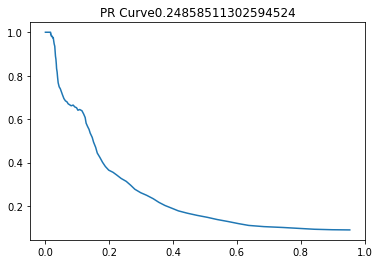

(6355,)
(69907,) (69907,)
AUC : 0.2534 


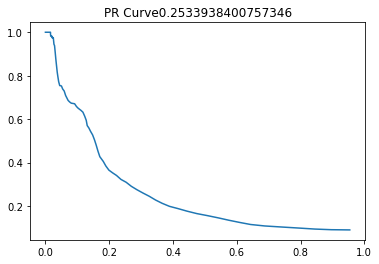

(6355,)
(69907,) (69907,)
AUC : 0.2505 


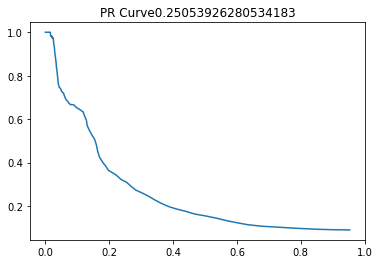

In [15]:
test(
    dagmm_obj,
    data_dict
)